In [2]:
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn import datasets 
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier

from statsmodels.stats import diagnostic
import statsmodels.api as sm

from scipy import stats
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.options.mode.chained_assignment=None

#Colormap used
viridis = plt.get_cmap('viridis', 12)

## Load the dataset
For all three questions, we load the london borough profiles data set. We see that it contains 85 variables measured over all the london boroughs, and it has 40 rows.

In [3]:
#save information in the dataframe boroughs
boroughs = pd.read_csv('./london-borough-profiles-2016-Data-set.csv')
boroughs.head()

,Code,New code,Area name,Inner/ Outer London,GLA Population Estimate 2016,GLA Household Estimate 2016,Inland Area (Hectares),Population density (per hectare) 2016,"Average Age, 2016","Proportion of population aged 0-15, 2016",...,Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10),Childhood Obesity Prevalance (%) 2014/15,People aged 17+ with diabetes (%),Mortality rate from causes considered preventable 2012/14,Political control in council,Proportion of seats won by Conservatives in 2014 election,Proportion of seats won by Labour in 2014 election,Proportion of seats won by Lib Dems in 2014 election,Turnout at 2014 local elections
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E09000001,E09000001,City of London,Inner London,"8,548","5,179",290.4,28.9,42.9,27.2,...,5.99,5.57,NaN,2.6,128.8,.,.,.,.,.
2,E09000002,E09000002,Barking and Dagenham,Outer London,"205,773","76,841","3,610.8",57.3,32.9,21.0,...,7.05,3.05,25.3,7.3,227.6,Lab,0.0,100.0,0.0,36.5
3,E09000003,E09000003,Barnet,Outer London,"385,108","149,147","8,674.8",44.5,37.2,21.0,...,7.37,2.75,18.4,6.0,133.8,Cons,50.8,47.6,1.6,40.5
4,E09000004,E09000004,Bexley,Outer London,"243,303","97,233","6,058.1",39.9,38.9,20.8,...,7.21,3.29,21.4,6.9,164.3,Cons,71.4,23.8,0.0,39.6


# Question 1 : Does location define life satisfaction or is it defined by standard of living (job, house price)?

In the first part of our research, we aimed to see whether location defined life satisfaction. We considered as 'location' whether the neighborhood was in Inner or Outer London. 

Linear regression are used to model the relationship between variables by fitting a linear equation to the observed data. One variable is considered to be an explanatory variable, and the others dependent variables. We used a least-squared regression (OLS) from the statsmodels.api package. 

We created three different models with different levels of controls in order to verify the veracity of our findings. In model 1, no controls were used as we only tried to predict life satisfaction in function of whether the borough was located in Inner or Outer London. In model 2, we added controls for health and safety in the neighborhood and in model 3 we additionally used controls for employment rates and income.

We then also tried to see if the standard of living could be used to predict life satisfaction. To do so, we chose to test a prediction with the criteria of salary, median house price, crime rates and if the house was owned outright. For all those additional variables we did not use any controls as we were only trying to find if any thing other than location could be used to predict life satisfaction.

### 1.1 Data Pre-processing

In [4]:
#We get rid of the first line because we see it only contains NaNs
boroughs = boroughs.drop([0],axis=0)

#### For life satisfaction, we take into consideration the following variables:
- Employment rate (%) (2015)
- Unemployment rate (2015)
- Gross Annual Pay, (2015)
- Modelled Households median income estimates 2012/13
- Jobs Density, 2014
- Crime rates per thousand population 2014/15
- Median House Price, 2014
- Homes Owned outright, 2014 (%)
- Being bought with mortgage or loan, (2014) %
- Rented from Local Authority or Housing Association, (2014) %
- % of area that is Greenspace, 2005
- Male life expectancy, (2012-2014)
- Female life expectancy, (2012-2014)
- Life satisfaction score 2011-14 (out of 10)
- Worthwhileness score 2011-14 (out of 10)
- Happiness score 2011-14 (out of 10)
- Anxiety score 2011-14 (out of 10)

In [5]:
variables_sat = boroughs[['Employment rate (%) (2015)', 'Unemployment rate (2015)', 'Gross Annual Pay, (2015)',
                   'Modelled Household median income estimates 2012/13', 'Jobs Density, 2014',
                   'Crime rates per thousand population 2014/15', 'Median House Price, 2014',
                   'Homes Owned outright, (2014) %', 'Being bought with mortgage or loan, (2014) %',
                   'Rented from Local Authority or Housing Association, (2014) %', 
                    '% of area that is Greenspace, 2005', 'Male life expectancy, (2012-14)',
                   'Female life expectancy, (2012-14)', 'Life satisfaction score 2011-14 (out of 10)',
                   'Worthwhileness score 2011-14 (out of 10)', 'Happiness score 2011-14 (out of 10)',
                   'Anxiety score 2011-14 (out of 10)']]

#In order to have our full dataframe, we also have to add the geographical information for each row
geo=boroughs[['Code','New code','Area name','Inner/ Outer London']]

#we thus create the final dataframe 'london_sat' containing all the valuable information for our prediction of satisfaction: 
london_sat=geo.join(variables_sat, how = 'inner')
london_sat.head(10)

,Code,New code,Area name,Inner/ Outer London,Employment rate (%) (2015),Unemployment rate (2015),"Gross Annual Pay, (2015)",Modelled Household median income estimates 2012/13,"Jobs Density, 2014",Crime rates per thousand population 2014/15,...,"Homes Owned outright, (2014) %","Being bought with mortgage or loan, (2014) %","Rented from Local Authority or Housing Association, (2014) %","% of area that is Greenspace, 2005","Male life expectancy, (2012-14)","Female life expectancy, (2012-14)",Life satisfaction score 2011-14 (out of 10),Worthwhileness score 2011-14 (out of 10),Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10)
1,E09000001,E09000001,City of London,Inner London,64.6,.,.,"£99,390",84.60,.,...,.,.,.,4.8,.,.,6.59,7.08,5.99,5.57
2,E09000002,E09000002,Barking and Dagenham,Outer London,65.8,11.0,"£28,428","£34,080",0.47,83.4,...,16.4,27.4,35.9,33.6,77.6,82.1,7.14,7.60,7.05,3.05
3,E09000003,E09000003,Barnet,Outer London,68.5,8.5,"£33,084","£54,530",0.69,62.7,...,32.4,25.2,11.1,41.3,82.1,85.1,7.48,7.76,7.37,2.75
4,E09000004,E09000004,Bexley,Outer London,75.1,7.6,"£32,040","£44,430",0.54,51.8,...,38.1,35.3,15.2,31.7,80.4,84.4,7.38,7.70,7.21,3.29
5,E09000005,E09000005,Brent,Outer London,69.5,7.5,"£29,777","£39,630",0.61,78.8,...,22.2,22.6,20.4,21.9,80.1,85.1,7.25,7.35,7.22,2.92
6,E09000006,E09000006,Bromley,Outer London,75.3,5.3,"£36,498","£55,140",0.64,64.1,...,37.8,34.9,13.2,57.8,81.4,84.9,7.54,7.86,7.44,3.26
7,E09000007,E09000007,Camden,Inner London,69.2,4.0,"£39,610","£67,990",2.25,123.5,...,18.5,15.1,34.4,24.8,81.8,86.7,7.14,7.38,7.11,3.61
8,E09000008,E09000008,Croydon,Outer London,75.4,4.1,"£32,887","£45,120",0.58,77.0,...,30.8,33.6,16.7,37.1,80.3,83.6,7.10,7.57,7.18,3.30
9,E09000009,E09000009,Ealing,Outer London,72.7,5.8,"£28,978","£45,690",0.70,75.5,...,20.1,30.2,14.3,30.9,80.6,84.2,7.29,7.57,7.26,3.57
10,E09000010,E09000010,Enfield,Outer London,73.0,3.8,"£31,094","£41,250",0.61,69.4,...,25.6,36.2,17.2,45.6,80.7,84.1,7.26,7.57,7.33,2.60


#### We then have to verifiy that all our data is useable

In [6]:
#First, we notice that when a value is missing it was replaced by a '.'. Thus, we have to change those for NaNs:
london_sat=london_sat.replace('.', np.nan)
london_sat.isna().sum()

Code                                                            1
New code                                                        1
Area name                                                       0
Inner/ Outer London                                             6
Employment rate (%) (2015)                                      0
Unemployment rate (2015)                                        1
Gross Annual Pay, (2015)                                        5
Modelled Household median income estimates 2012/13              0
Jobs Density, 2014                                              0
Crime rates per thousand population 2014/15                     2
Median House Price, 2014                                        0
Homes Owned outright, (2014) %                                  1
Being bought with mortgage or loan, (2014) %                    1
Rented from Local Authority or Housing Association, (2014) %    1
% of area that is Greenspace, 2005                              1
Male life 

In [7]:
#Second, I verify the types of value for each column
london_sat.dtypes

Code                                                             object
New code                                                         object
Area name                                                        object
Inner/ Outer London                                              object
Employment rate (%) (2015)                                      float64
Unemployment rate (2015)                                         object
Gross Annual Pay, (2015)                                         object
Modelled Household median income estimates 2012/13               object
Jobs Density, 2014                                              float64
Crime rates per thousand population 2014/15                      object
Median House Price, 2014                                         object
Homes Owned outright, (2014) %                                   object
Being bought with mortgage or loan, (2014) %                     object
Rented from Local Authority or Housing Association, (2014) %    

As we cannot correctly use the 'object' type, I choose to change those into numerics.

In [8]:
#However, there are some characters that cannot be transformed: 
london_sat['Gross Annual Pay, (2015)']=london_sat['Gross Annual Pay, (2015)'].str.replace('£','')
london_sat['Gross Annual Pay, (2015)']=london_sat['Gross Annual Pay, (2015)'].str.replace(',','')
london_sat['Modelled Household median income estimates 2012/13']=london_sat['Modelled Household median income estimates 2012/13'].str.replace('£','')
london_sat['Modelled Household median income estimates 2012/13']=london_sat['Modelled Household median income estimates 2012/13'].str.replace(',','')
london_sat['Median House Price, 2014'] = london_sat['Median House Price, 2014'].str.replace(',','')
london_sat.head()


,Code,New code,Area name,Inner/ Outer London,Employment rate (%) (2015),Unemployment rate (2015),"Gross Annual Pay, (2015)",Modelled Household median income estimates 2012/13,"Jobs Density, 2014",Crime rates per thousand population 2014/15,...,"Homes Owned outright, (2014) %","Being bought with mortgage or loan, (2014) %","Rented from Local Authority or Housing Association, (2014) %","% of area that is Greenspace, 2005","Male life expectancy, (2012-14)","Female life expectancy, (2012-14)",Life satisfaction score 2011-14 (out of 10),Worthwhileness score 2011-14 (out of 10),Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10)
1,E09000001,E09000001,City of London,Inner London,64.6,NaN,NaN,99390,84.60,NaN,...,NaN,NaN,NaN,4.8,NaN,NaN,6.59,7.08,5.99,5.57
2,E09000002,E09000002,Barking and Dagenham,Outer London,65.8,11.0,28428,34080,0.47,83.4,...,16.4,27.4,35.9,33.6,77.6,82.1,7.14,7.60,7.05,3.05
3,E09000003,E09000003,Barnet,Outer London,68.5,8.5,33084,54530,0.69,62.7,...,32.4,25.2,11.1,41.3,82.1,85.1,7.48,7.76,7.37,2.75
4,E09000004,E09000004,Bexley,Outer London,75.1,7.6,32040,44430,0.54,51.8,...,38.1,35.3,15.2,31.7,80.4,84.4,7.38,7.70,7.21,3.29
5,E09000005,E09000005,Brent,Outer London,69.5,7.5,29777,39630,0.61,78.8,...,22.2,22.6,20.4,21.9,80.1,85.1,7.25,7.35,7.22,2.92


In [9]:
#We also remove households where the information about life satisfaction isn't complete
london_sat = london_sat[~london_sat['Inner/ Outer London'].isna()] 

In [10]:
#Changing all "objects" into numerics

london_sat['Unemployment rate (2015)'] = pd.to_numeric(london_sat['Unemployment rate (2015)'])
london_sat['Gross Annual Pay, (2015)'] = pd.to_numeric(london_sat['Gross Annual Pay, (2015)'])
london_sat['Modelled Household median income estimates 2012/13'] = pd.to_numeric(london_sat['Modelled Household median income estimates 2012/13'])

london_sat['Crime rates per thousand population 2014/15'] = pd.to_numeric(london_sat['Crime rates per thousand population 2014/15'])
london_sat['Median House Price, 2014'] = pd.to_numeric(london_sat['Median House Price, 2014'])
london_sat['Homes Owned outright, (2014) %'] = pd.to_numeric(london_sat['Homes Owned outright, (2014) %'])
london_sat['Being bought with mortgage or loan, (2014) %'] = pd.to_numeric(london_sat['Being bought with mortgage or loan, (2014) %'])
london_sat['Rented from Local Authority or Housing Association, (2014) %'] = pd.to_numeric(london_sat['Rented from Local Authority or Housing Association, (2014) %'])
london_sat['% of area that is Greenspace, 2005'] = pd.to_numeric(london_sat['% of area that is Greenspace, 2005'])
london_sat['Male life expectancy, (2012-14)'] = pd.to_numeric(london_sat['Male life expectancy, (2012-14)'])
london_sat['Female life expectancy, (2012-14)'] = pd.to_numeric(london_sat['Female life expectancy, (2012-14)'])

london_sat.dtypes

Code                                                             object
New code                                                         object
Area name                                                        object
Inner/ Outer London                                              object
Employment rate (%) (2015)                                      float64
Unemployment rate (2015)                                        float64
Gross Annual Pay, (2015)                                        float64
Modelled Household median income estimates 2012/13                int64
Jobs Density, 2014                                              float64
Crime rates per thousand population 2014/15                     float64
Median House Price, 2014                                          int64
Homes Owned outright, (2014) %                                  float64
Being bought with mortgage or loan, (2014) %                    float64
Rented from Local Authority or Housing Association, (2014) %    

Finally, we have to decide what to do with Nans in the dataframe: 
As we are going to do a regression, I choose to set all the Nans to zeros. 

In [11]:
#Before filling all Nans with 0, we have: 
london_sat.isna().sum()

Code                                                            0
New code                                                        0
Area name                                                       0
Inner/ Outer London                                             0
Employment rate (%) (2015)                                      0
Unemployment rate (2015)                                        1
Gross Annual Pay, (2015)                                        3
Modelled Household median income estimates 2012/13              0
Jobs Density, 2014                                              0
Crime rates per thousand population 2014/15                     1
Median House Price, 2014                                        0
Homes Owned outright, (2014) %                                  1
Being bought with mortgage or loan, (2014) %                    1
Rented from Local Authority or Housing Association, (2014) %    1
% of area that is Greenspace, 2005                              0
Male life 

In [12]:
#After filling all Nans with 0:
london_sat=london_sat.fillna(0)
london_sat.isna().sum()

Code                                                            0
New code                                                        0
Area name                                                       0
Inner/ Outer London                                             0
Employment rate (%) (2015)                                      0
Unemployment rate (2015)                                        0
Gross Annual Pay, (2015)                                        0
Modelled Household median income estimates 2012/13              0
Jobs Density, 2014                                              0
Crime rates per thousand population 2014/15                     0
Median House Price, 2014                                        0
Homes Owned outright, (2014) %                                  0
Being bought with mortgage or loan, (2014) %                    0
Rented from Local Authority or Housing Association, (2014) %    0
% of area that is Greenspace, 2005                              0
Male life 

### Data visualisation for question 1

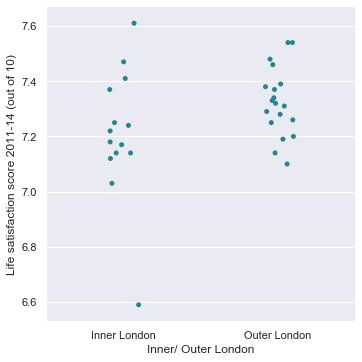

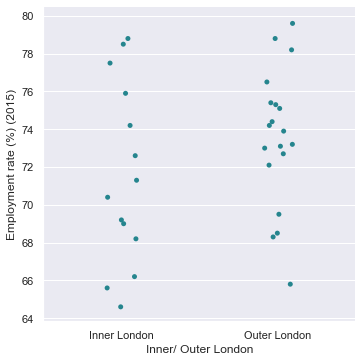

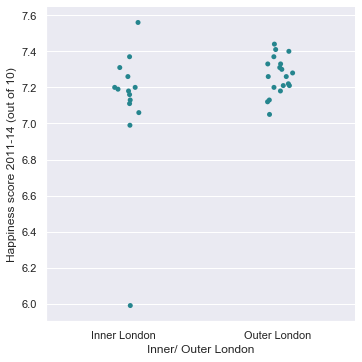

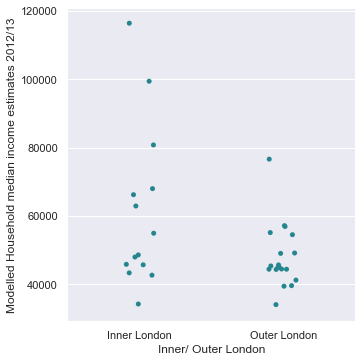

In [13]:
#Visualise the happiness, life satisfaction, employment rate and median household income variables based on the inner/outer london categorical variable
sns.set(rc={'figure.figsize':(10,10)})
sns.catplot(x='Inner/ Outer London', y='Life satisfaction score 2011-14 (out of 10)', 
            data=london_sat, color = viridis.colors[5])

sns.catplot(x='Inner/ Outer London', y='Employment rate (%) (2015)', 
            data = london_sat, color = viridis.colors[5])

sns.catplot(x='Inner/ Outer London', y='Happiness score 2011-14 (out of 10)', 
            data=london_sat, color = viridis.colors[5])

sns.catplot(x='Inner/ Outer London', y='Modelled Household median income estimates 2012/13', 
            data=london_sat, color = viridis.colors[5])

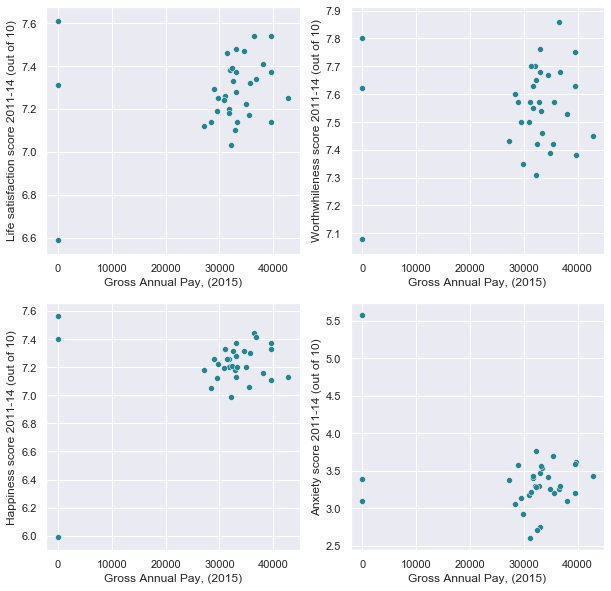

In [14]:
#Visualise the four well-being variables based on the gross annual pay variable
fig, axs = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x='Gross Annual Pay, (2015)', 
                y='Life satisfaction score 2011-14 (out of 10)', data=london_sat, ax=axs[0, 0],
               color = viridis.colors[5])

sns.scatterplot(x='Gross Annual Pay, (2015)', 
                y='Worthwhileness score 2011-14 (out of 10)', data=london_sat, ax=axs[0, 1],
               color = viridis.colors[5])

sns.scatterplot(x='Gross Annual Pay, (2015)', 
                y='Happiness score 2011-14 (out of 10)', data=london_sat, ax=axs[1, 0],
               color = viridis.colors[5])

sns.scatterplot(x='Gross Annual Pay, (2015)', 
                y='Anxiety score 2011-14 (out of 10)', data=london_sat, ax=axs[1, 1],
               color = viridis.colors[5])

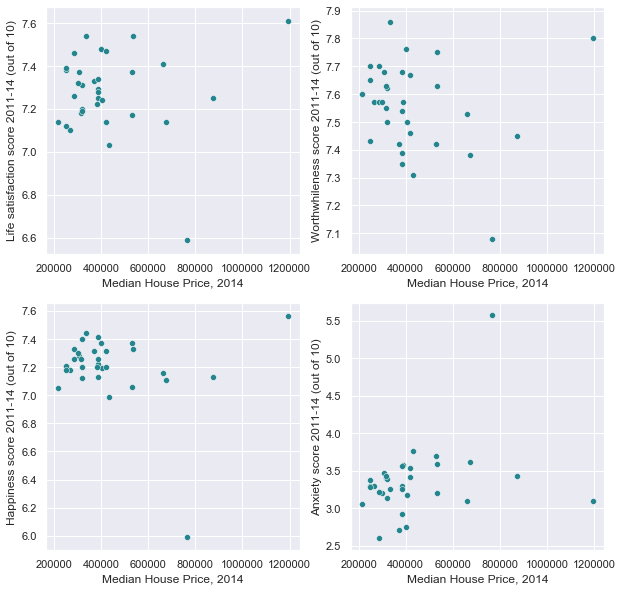

In [15]:
#Visualise the four well-being variables based on the house price
fig, axs = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x='Median House Price, 2014', 
                y='Life satisfaction score 2011-14 (out of 10)', data=london_sat, ax=axs[0, 0], 
                color = viridis.colors[5])

sns.scatterplot(x='Median House Price, 2014', 
                y='Worthwhileness score 2011-14 (out of 10)', data=london_sat, ax=axs[0, 1],
               color = viridis.colors[5])

sns.scatterplot(x='Median House Price, 2014', 
                y='Happiness score 2011-14 (out of 10)', data=london_sat, ax=axs[1, 0],
               color = viridis.colors[5])

sns.scatterplot(x='Median House Price, 2014', 
                y='Anxiety score 2011-14 (out of 10)', data=london_sat, ax=axs[1, 1],
               color = viridis.colors[5])

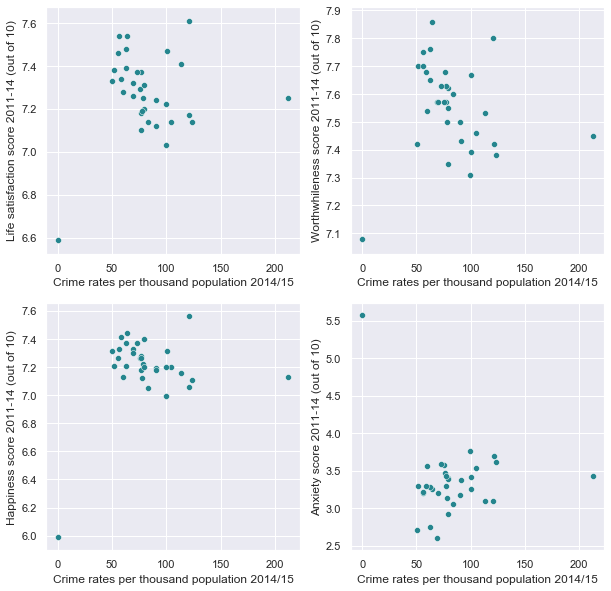

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x='Crime rates per thousand population 2014/15', 
                y='Life satisfaction score 2011-14 (out of 10)', data=london_sat, ax=axs[0, 0],
               color = viridis.colors[5])

sns.scatterplot(x='Crime rates per thousand population 2014/15', 
                y='Worthwhileness score 2011-14 (out of 10)', data=london_sat, ax=axs[0, 1],
               color = viridis.colors[5])

sns.scatterplot(x='Crime rates per thousand population 2014/15', 
                y='Happiness score 2011-14 (out of 10)', data=london_sat, ax=axs[1, 0],
               color = viridis.colors[5])

sns.scatterplot(x='Crime rates per thousand population 2014/15', 
                y='Anxiety score 2011-14 (out of 10)', data=london_sat, ax=axs[1, 1],
               color = viridis.colors[5])

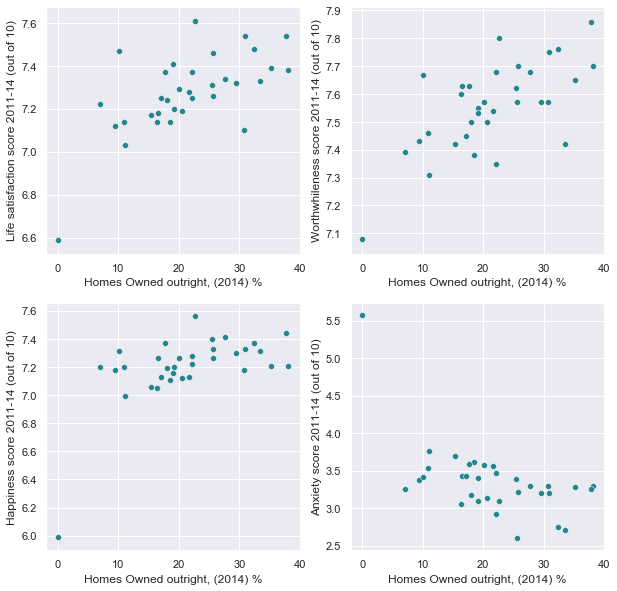

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
sns.scatterplot(x='Homes Owned outright, (2014) %', 
                y='Life satisfaction score 2011-14 (out of 10)', data=london_sat, ax=axs[0, 0],
               color = viridis.colors[5])

sns.scatterplot(x='Homes Owned outright, (2014) %', 
                y='Worthwhileness score 2011-14 (out of 10)', data=london_sat, ax=axs[0, 1],
               color = viridis.colors[5])

sns.scatterplot(x='Homes Owned outright, (2014) %', 
                y='Happiness score 2011-14 (out of 10)', data=london_sat, ax=axs[1, 0],
               color = viridis.colors[5])

sns.scatterplot(x='Homes Owned outright, (2014) %', 
                y='Anxiety score 2011-14 (out of 10)', data=london_sat, ax=axs[1, 1],
               color = viridis.colors[5])

As a last step, as we will try to predict whether a neighborhood is in the Inner or Outer London, we have to create a new columns that will hold the values 0 for Outer and 1 for Inner:


In [18]:
def InOutLondon(df):
    
    binary =np.empty(len(df))
    val=df['Inner/ Outer London']
    
    for i in range(0,len(df)):
        if (val.iloc[i]=='Inner London'):
            binary[i]=True
        if(val.iloc[i]=='Outer London'):
            binary[i]=False
            
    return binary

In [19]:
Inner_Outer_London=InOutLondon(london_sat)
london_sat['InOutLondon']=Inner_Outer_London

In [20]:
#We also want to add dummy variables for any column were there are 0.0: 

#Here we add the dummy variables

#dummy variables for model 2 and 3
london_sat['dummy_crimerates']=london_sat['Crime rates per thousand population 2014/15'].isna().astype(np.int8)
london_sat['dummy_greenspace']=london_sat['% of area that is Greenspace, 2005'].isna().astype(np.int8)
london_sat['dummy_malelife']=london_sat['Male life expectancy, (2012-14)'].isna().astype(np.int8)
london_sat['dummy_femalelife']=london_sat['Female life expectancy, (2012-14)'].isna().astype(np.int8)

#dummy variable for model 3
london_sat['dummy_unemploy']=london_sat['Unemployment rate (2015)'].isna().astype(np.int8)
london_sat['dummy_grossannualpay']=london_sat['Gross Annual Pay, (2015)'].isna().astype(np.int8)
london_sat['dummy_mediancome']=london_sat['Modelled Household median income estimates 2012/13'].isna().astype(np.int8)
london_sat['dummy_jobdensity']=london_sat['Jobs Density, 2014'].isna().astype(np.int8)
london_sat['dummy_medhouseprice']=london_sat['Median House Price, 2014'].isna().astype(np.int8)
london_sat['dummy_mortgageorloan']=london_sat['Being bought with mortgage or loan, (2014) %'].isna().astype(np.int8)
london_sat['dummy_localautho']=london_sat['Rented from Local Authority or Housing Association, (2014) %'].isna().astype(np.int8)


#### Here, we will first study how location and life satisfaction are correlated: 
More specifically, we look if the location (inner or outer london) affects life satisfaction. 
We choose to take into account for life satisfaction the criteria: 
- Life satisfaction score 2011-14 (out of 10)',
- 'Worthwhileness score 2011-14 (out of 10)',
- 'Happiness score 2011-14 (out of 10)',
- 'Anxiety score 2011-14 (out of 10)',

### 1.2 - Model 1: No control

In [21]:
np.random.seed(2)

In [22]:
cols=['Life satisfaction score 2011-14 (out of 10)','Worthwhileness score 2011-14 (out of 10)','Happiness score 2011-14 (out of 10)','Anxiety score 2011-14 (out of 10)']
Y=london_sat[cols]

X=london_sat['InOutLondon']
X=sm.add_constant(X)

c1=np.zeros(4)
inter1 = np.zeros(4)
sd1=np.zeros(4)
p1=np.zeros(4)

for i in range (0,Y.shape[1]):
    mod=sm.OLS(Y.iloc[:,i],X)
    res = mod.fit()
    c1[i]=res.params[1]
    inter1[i]=res.params[0]
    sd1[i]=res.bse[1]
    p1[i]=res.pvalues[1]
print("Pvalue",p1)
print("Intercept coefficient, model 1", inter1)
print("Coefficient for location, model 1:",c1)

Pvalue [0.08073966 0.01320498 0.10823722 0.0205982 ]
Intercept coefficient, model 1 [7.32473684 7.61263158 7.26368421 3.18947368]
Coefficient for location, model 1: [-0.11473684 -0.13548872 -0.14154135  0.38481203]


### 1.3 - Model 2: Controls of health and safety

To do so, we use the variables below as controls: 
- % of area that is Greenspace, 2005                             
- Male life expectancy, (2012-14)                                
- Female life expectancy, (2012-14)
- Crime rates per thousand population 2014/15

In [23]:
cols=['Life satisfaction score 2011-14 (out of 10)','Worthwhileness score 2011-14 (out of 10)','Happiness score 2011-14 (out of 10)','Anxiety score 2011-14 (out of 10)']
Y=london_sat[cols]

X=london_sat[['InOutLondon','% of area that is Greenspace, 2005','Male life expectancy, (2012-14)','Female life expectancy, (2012-14)','Crime rates per thousand population 2014/15','dummy_greenspace','dummy_malelife','dummy_femalelife','dummy_crimerates']]
X=sm.add_constant(X)

c2=np.zeros(4)
inter2=np.zeros(4)
sd2=np.zeros(4)
p2=np.zeros(4)

for i in range (0,Y.shape[1]):
    mod=sm.OLS(Y.iloc[:,i],X)
    res = mod.fit()
    c2[i]=res.params[1]
    inter2[i]=res.params[0]
    sd2[i]=res.bse[1]
    p2[i]=res.pvalues[1]

print("Pvalue:",p2)

Pvalue: [0.11112941 0.08457246 0.04326657 0.22496639]


### 1.4 - Model 3: Controls of health, safety, employment and income

To do so, we use the following variables as controls: 
- % of area that is Greenspace, 2005                             
- Male life expectancy, (2012-14)                                
- Female life expectancy, (2012-14)
- Crime rates per thousand population 2014/15
- Median House Price, 2014                                     
- Being bought with mortgage or loan, (2014) %                    
- Rented from Local Authority or Housing Association, (2014) %
- Unemployment rate (2015)                                        
- Gross Annual Pay, (2015)                                        
- Modelled Household median income estimates 2012/13              
- Jobs Density, 2014    

In [24]:
cols=['Life satisfaction score 2011-14 (out of 10)','Worthwhileness score 2011-14 (out of 10)','Happiness score 2011-14 (out of 10)','Anxiety score 2011-14 (out of 10)']
Y=london_sat[cols]

X=london_sat[['InOutLondon','% of area that is Greenspace, 2005','Male life expectancy, (2012-14)','Female life expectancy, (2012-14)','Crime rates per thousand population 2014/15','Median House Price, 2014','Being bought with mortgage or loan, (2014) %','Rented from Local Authority or Housing Association, (2014) %','Unemployment rate (2015)','Gross Annual Pay, (2015)','Modelled Household median income estimates 2012/13','Jobs Density, 2014','dummy_greenspace','dummy_malelife','dummy_femalelife','dummy_crimerates','dummy_unemploy','dummy_grossannualpay','dummy_mediancome','dummy_jobdensity','dummy_medhouseprice','dummy_mortgageorloan','dummy_localautho']]
X=sm.add_constant(X)

c3=np.zeros(4)
sd3=np.zeros(4)
p3=np.zeros(4)

for i in range (0,Y.shape[1]):
    mod=sm.OLS(Y.iloc[:,i],X)
    res = mod.fit()
    c3[i]=res.params[1]
    sd3[i]=res.bse[1]
    p3[i]=res.pvalues[1]

print("Pvalue ",p3)

Pvalue  [0.06932474 0.09631843 0.00448888 0.95740339]


### 1.5 - Verification of the p-values and presentation of the results for the first question

In [25]:
data={'Model 1': p1,
        'Model 2': p2,
        'Model 3': p3,
        }

pval=pd.DataFrame(data, index=["Life satisfaction score 2011-14 (out of 10)", 
                               "Worthwhileness score 2011-14 (out of 10)", 
                               'Happiness score 2011-14 (out of 10)',
                               'Anxiety score 2011-14 (out of 10)'], 
                columns = ['Model 1',
                           'Model 2',
                           'Model 3'])

print('Title: P-values obtained for each model')
pval

Title: P-values obtained for each model


,Model 1,Model 2,Model 3
Life satisfaction score 2011-14 (out of 10),0.080740,0.111129,0.069325
Worthwhileness score 2011-14 (out of 10),0.013205,0.084572,0.096318
Happiness score 2011-14 (out of 10),0.108237,0.043267,0.004489
Anxiety score 2011-14 (out of 10),0.020598,0.224966,0.957403


Title: P-values obtained for each model


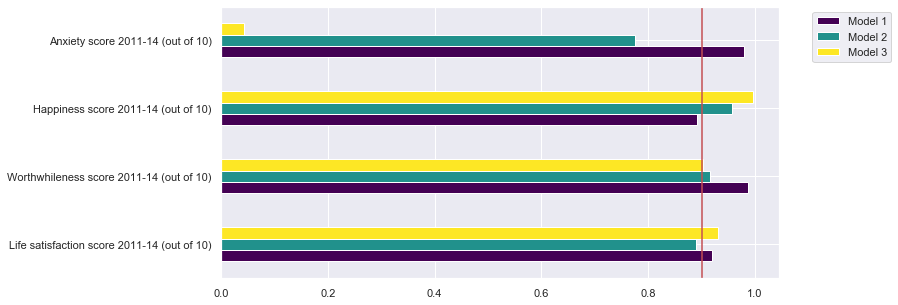

In [26]:
p1_2=1-p1
p2_2=1-p2
p3_2=1-p3

data={'Model 1': p1_2,
        'Model 2': p2_2,
        'Model 3': p3_2,
        }

pvalm=pd.DataFrame(data, index=["Life satisfaction score 2011-14 (out of 10)", 
                               "Worthwhileness score 2011-14 (out of 10)", 
                               'Happiness score 2011-14 (out of 10)',
                               'Anxiety score 2011-14 (out of 10)'], 
                columns = ['Model 1',
                           'Model 2',
                           'Model 3'])

print('Title: P-values obtained for each model')
pvalm

pvalm.plot(kind="barh", width=0.5, figsize=(10,5), cmap=plt.get_cmap('viridis'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axvline(0.90,0,1,color='r')

### Conclusion for this first part of question 1:
The red line on the histogram is here to show that any bar that goes further than it has a p-value of less than 0.10 (we chose to plot 1 - pvalue for visualisation in our data story, so any bar going further than 0.90 corresponds to a pvalue inferior to 0.10), which means that location is significant to assess all these scores at a 10% significance level. 

We can deduce that the life satisfaction score, the worthwhileness score as well as the happiness score can very well be predicted from location in all three models (with or without control variables). 

However, the location is only significant for the anxiety score when using the model 1. When adding some controls, we see that the inner/outer location variable pvalue increases drastiscally until it is not significant anymore. It means that the anxiety score does not significantly depend on the inner/outer location, but rather on other parameters. 

#### Interpretation of the coefficients for the significant pvalues
The models we use follow this formula: $y = b_0 + b_1x_1 + \sum{b_nx_n}$, where $y$ is one of the four well-being variables; $b_0$ and $b_1$ are the coefficients found through OLS, and $x_1$ is equal to 1 if the borough is in inner London.
- For model 1, $\sum{b_nx_n}$
- For model 2, $\sum{b_nx_n}$ contains the health and safety control variables
- For model 3, $\sum{b_nx_n}$ contains health, safety, employment, and income control variables

But we are in the end only interested in the $b_1$ coefficient. As anxiety is not significantly influenced by location, we would not look further at that variable. For the three other variables, we will interpret the coefficient of the model 3, in which the location appears significant for all three variables. 

We see that for the life satisfaction, worthwhileness and happiness scores, the coefficient $b_1$ is negative, which means that an inner borough has these scores penalized by the $b_1$ coefficient. It means that outer boroughs have higher scores for these three variables. The coefficients $b_1$ for the life satisfaction, worthwhileness and happiness are respectively: 0.14,  0.11, 0.20, all positive. As $x_1$ is equal to 1 if a borough is in inner London, it means that people living in inner London are more satisfied with their life, happier, and have a high worthwhileness score.

Overall, outer boroughs seems to have higher well-being scores when looking at location.

### 1.6 - Model 1 modified to test life satisfaction in function of salary

In [27]:
np.random.seed(2)

In [28]:
cols=['Life satisfaction score 2011-14 (out of 10)','Worthwhileness score 2011-14 (out of 10)','Happiness score 2011-14 (out of 10)','Anxiety score 2011-14 (out of 10)']
Y=london_sat[cols]

X=london_sat['Gross Annual Pay, (2015)']
X=sm.add_constant(X)

c5=np.zeros(4)
inter5 = np.zeros(4)
sd5=np.zeros(4)
p5=np.zeros(4)

for i in range (0,Y.shape[1]):
    mod=sm.OLS(Y.iloc[:,i],X)
    res = mod.fit()
    c5[i]=res.params[1]
    inter5[i]=res.params[0]
    sd5[i]=res.bse[1]
    p5[i]=res.pvalues[1]
print("Pvalue",p5)
print("Intercept coefficient for gross annual pay",inter5)
print("Coefficient for gross annual pay",c5)

Pvalue [0.164269   0.4555749  0.09726167 0.03204869]
Intercept coefficient for gross annual pay [7.1403693  7.49235356 6.98888379 3.88028815]
Coefficient for gross annual pay [ 4.43936809e-06  2.05454035e-06  7.02598987e-06 -1.72600369e-05]


### 1.7 - Model 1 modified to test life satisfaction in function of house price

In [29]:
cols=['Life satisfaction score 2011-14 (out of 10)','Worthwhileness score 2011-14 (out of 10)','Happiness score 2011-14 (out of 10)','Anxiety score 2011-14 (out of 10)']
Y=london_sat[cols]

X=london_sat['Median House Price, 2014']
X=sm.add_constant(X)

c6=np.zeros(4)
inter6=np.zeros(4)
sd6=np.zeros(4)
p6=np.zeros(4)

for i in range (0,Y.shape[1]):
    mod=sm.OLS(Y.iloc[:,i],X)
    res = mod.fit()
    c6[i]=res.params[1]
    inter6[i]=res.params[0]
    sd6[i]=res.bse[1]
    p6[i]=res.pvalues[1]
print("Pvalue",p6)
print("Intercept coefficient for house price",inter6)
print("Coefficient for house price",c6)


Pvalue [0.87626266 0.42754789 0.38781452 0.094289  ]
Intercept coefficient for house price [7.26510626 7.60252895 7.28434028 3.05615028]
Coefficient for house price [ 2.55329032e-08 -1.10429491e-07 -1.88108402e-07  6.91275268e-07]


### 1.8 - Model 1 modified to test life satisfaction in function of Crime rates per thousand population 2014/15

In [30]:
cols=['Life satisfaction score 2011-14 (out of 10)','Worthwhileness score 2011-14 (out of 10)','Happiness score 2011-14 (out of 10)','Anxiety score 2011-14 (out of 10)']
Y=london_sat[cols]

X=london_sat['Crime rates per thousand population 2014/15']
X=sm.add_constant(X)

c7=np.zeros(4)
sd7=np.zeros(4)
p7=np.zeros(4)

for i in range (0,Y.shape[1]):
    mod=sm.OLS(Y.iloc[:,i],X)
    res = mod.fit()
    c7[i]=res.params[1]
    sd7[i]=res.bse[1]
    p7[i]=res.pvalues[1]
print("Pvalue",p7)
print("Coefficient for crime rates",c7)


Pvalue [0.49904269 0.71029839 0.17389415 0.25727253]
Coefficient for crime rates [ 0.00066928 -0.00031453  0.00177861 -0.00287109]


### 1.9 - Model 1 modified to test life satisfaction in function of Homes Owned outright


In [31]:
cols=['Life satisfaction score 2011-14 (out of 10)','Worthwhileness score 2011-14 (out of 10)','Happiness score 2011-14 (out of 10)','Anxiety score 2011-14 (out of 10)']
Y=london_sat[cols]

X=london_sat['Homes Owned outright, (2014) %']
X=sm.add_constant(X)

c8=np.zeros(4)
sd8=np.zeros(4)
p8=np.zeros(4)

for i in range (0,Y.shape[1]):
    mod=sm.OLS(Y.iloc[:,i],X)
    res = mod.fit()
    c8[i]=res.params[1]
    sd8[i]=res.bse[1]
    p8[i]=res.pvalues[1]
print("Pvalue:", p8)
print("Coefficient for homes owned outright", c8)

Pvalue: [6.91365228e-05 2.33016754e-05 5.92287716e-04 4.50134428e-04]
Coefficient for homes owned outright [ 0.01305621  0.01166019  0.01552908 -0.03047323]


### 1.10 - Verification of the p-values and presentation of the results

In [32]:
data={'Location': p1,
      'Gross Annual Pay': p5,
        'Median house price': p6,
        'Crime rates': p7,
        'Homes owned outright': p8,
        }

pval=pd.DataFrame(data, index=["Life satisfaction score 2011-14 (out of 10)", 
                               "Worthwhileness score 2011-14 (out of 10)", 
                               'Happiness score 2011-14 (out of 10)',
                               'Anxiety score 2011-14 (out of 10)'], 
                columns = ['Location',
                           'Gross Annual Pay',
                           'Median house price',
                          'Crime rates',
                          'Homes owned outright'])

print('Title: P-values obtained for each model')
pval

Title: P-values obtained for each model


,Location,Gross Annual Pay,Median house price,Crime rates,Homes owned outright
Life satisfaction score 2011-14 (out of 10),0.080740,0.164269,0.876263,0.499043,0.000069
Worthwhileness score 2011-14 (out of 10),0.013205,0.455575,0.427548,0.710298,0.000023
Happiness score 2011-14 (out of 10),0.108237,0.097262,0.387815,0.173894,0.000592
Anxiety score 2011-14 (out of 10),0.020598,0.032049,0.094289,0.257273,0.000450


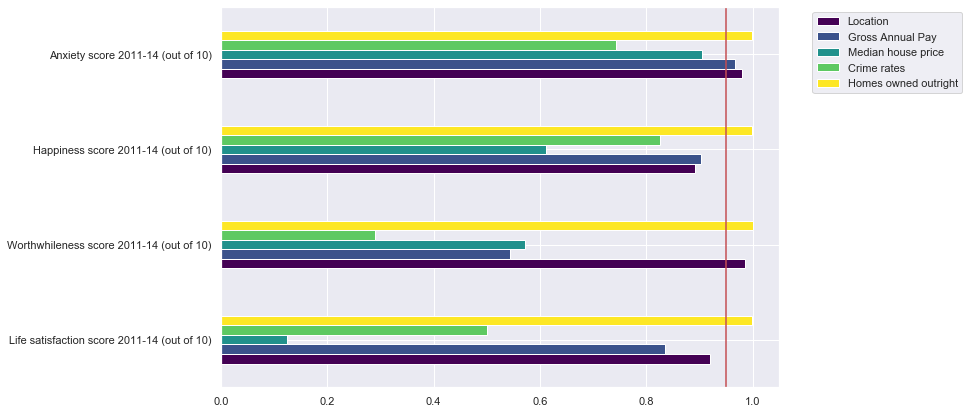

In [33]:
p1_2=1-p1
p5_2=1-p5
p6_2=1-p6
p7_2=1-p7
p8_2=1-p8

data={'Location': p1_2,
      'Gross Annual Pay': p5_2,
        'Median house price': p6_2,
        'Crime rates': p7_2,
        'Homes owned outright': p8_2,
        }

pvalm2=pd.DataFrame(data, index=["Life satisfaction score 2011-14 (out of 10)", 
                               "Worthwhileness score 2011-14 (out of 10)", 
                               'Happiness score 2011-14 (out of 10)',
                               'Anxiety score 2011-14 (out of 10)'], 
                columns = ['Location',
                           'Gross Annual Pay',
                           'Median house price',
                          'Crime rates',
                          'Homes owned outright'])


pvalm2.plot(kind="barh", width=0.5, figsize=(10,7), cmap=plt.get_cmap('viridis'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axvline(0.95,0,1,color='r')

#### Conclusion for this part of question 1:
When looking at standard of living variables to establish whether they are more significant can the location to predict the well-being of people, we first see that the crime rates per thousand population alone cannot predict any of these scores. 

For the median house price alone, we see that it is quite efficient to predict the anxiety score, but not the other scores. From coefficients, we see that a more expensive home leads to higher anxiety, as the coefficient for the house price with anxiety as an outcome variable is positive.

In terms of gross annual pay, using the coefficient and the pvalue, it is not surprising to find that earning more money can significantly help reducing your anxiety. However, it is not significant for the other variables.

But what’s interesting here, is that how you own your house is a powerful predictor for all 4 scores. Having your home owned outright, that is, having full possession of your home (you paid all of it directly with your own money and received no loan) has a significant influence on your life satisfaction, happiness, worthwhileness and anxiety. From the coefficients, we see that having your home owned outright results in higher life satisfactio, worthwhileness and happiness, and lower anxiety.

# Question 2: Can we group neighborhoods by looking at well being, security and economic stability?
This question is an extension of the question 1. Indeed, in the question 1, we study the possibility for the location to define the life satisfaction and happiness. However, we only consider location as inner/outer london. Here, we are going to determine for each neighborhood if it can be linked to others based on well-being, as well as life and housing conditions.

To do so, we first select variables of interest, and we then use a principal component analysis (PCA), to determine the principal components.

Principal Component Analysis is used as a way to obtain a reduction of dimensionality, particularly useful for subsequent clustering and embedding analysis. We use it here to determine the importance of each feature. We then keep the 2 first principal components, to visualize the embedding of the London neighborhoods. This allows the further analysis of the data through clustering. The PCA function used is from the scikit-learn python package.

These plots guide the choices for the number of clusters indicated to the "k-means" function, in order to possibly group neighborhoods based on well being, security and economic stability.

Clustering of neighborhoods is achieved using k-means. That algorithm aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. The number of clusters, k, is usually visually defined based on qualitative visualisation of the data embedding.
The k-means function used is from the scikit-learn package.

A lot of data pre-processing has already been done in question 1 (see above). 

### 2.1 - Data Pre-processing
#### Select variables that could be useful for life satisfaction:
Based on the data exploration and our thinking, we select all variables that could influence the grouping of boroughs; that is, choose features that might be different between London boroughs.
- Employment rate (%) (2015)
- Modelled Households median income estimates 2012/13
- Crime rates per thousand population 2014/15
- Homes Owned outright, 2014 (%)
- Being bought with mortgage or loan, (2014) %
- Rented from Local Authority or Housing Association, (2014) %
- Life satisfaction score 2011-14 (out of 10)
- Worthwhileness score 2011-14 (out of 10)
- Happiness score 2011-14 (out of 10)
- Anxiety score 2011-14 (out of 10)

In [34]:
#Select all variables we might want to use, that are independent variables or control variables
PCA_variables = boroughs[['Employment rate (%) (2015)','Modelled Household median income estimates 2012/13',
                          'Crime rates per thousand population 2014/15', 'Homes Owned outright, (2014) %',
                          'Life satisfaction score 2011-14 (out of 10)','Worthwhileness score 2011-14 (out of 10)', 
                          'Happiness score 2011-14 (out of 10)','Anxiety score 2011-14 (out of 10)']]

#We then create a dataframe with the boroughs information (code, area):
PCA_boroughs = boroughs[['New code', 'Area name', 'Inner/ Outer London']]

#We join the two dataframes:
PCA_df = PCA_boroughs.join(PCA_variables, how = 'inner')

In [35]:
#Check the final dataframe:
PCA_df.head()

,New code,Area name,Inner/ Outer London,Employment rate (%) (2015),Modelled Household median income estimates 2012/13,Crime rates per thousand population 2014/15,"Homes Owned outright, (2014) %",Life satisfaction score 2011-14 (out of 10),Worthwhileness score 2011-14 (out of 10),Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10)
1,E09000001,City of London,Inner London,64.6,"£99,390",.,.,6.59,7.08,5.99,5.57
2,E09000002,Barking and Dagenham,Outer London,65.8,"£34,080",83.4,16.4,7.14,7.60,7.05,3.05
3,E09000003,Barnet,Outer London,68.5,"£54,530",62.7,32.4,7.48,7.76,7.37,2.75
4,E09000004,Bexley,Outer London,75.1,"£44,430",51.8,38.1,7.38,7.70,7.21,3.29
5,E09000005,Brent,Outer London,69.5,"£39,630",78.8,22.2,7.25,7.35,7.22,2.92


In [36]:
#Check if in the selected variables, we have any missing values:
#Also, we see that some missing values have been overwritten with '.' 
#and thus not appear as missing values: we need to reverse this first before checking the missing values:
PCA_df = PCA_df.replace('.', np.nan)

In [37]:
#We drop the rows with NA in 'Inner/Outer London' because we see that it is only for "not boroughs" rows 
# (all of London, UK, ...)
PCA_df = PCA_df[~PCA_df['Inner/ Outer London'].isna()]

In [38]:
#Get out any sign that cannot be converted directly to numeric
PCA_df['Modelled Household median income estimates 2012/13'] = PCA_df['Modelled Household median income estimates 2012/13'].str.replace('£','')
PCA_df['Modelled Household median income estimates 2012/13'] = PCA_df['Modelled Household median income estimates 2012/13'].str.replace(',','')

In [39]:
#Put object dtypes to numeric when the variables is numeric
PCA_df['Modelled Household median income estimates 2012/13'] = pd.to_numeric(PCA_df['Modelled Household median income estimates 2012/13'])
PCA_df['Crime rates per thousand population 2014/15'] = pd.to_numeric(PCA_df['Crime rates per thousand population 2014/15'])
PCA_df['Homes Owned outright, (2014) %'] = pd.to_numeric(PCA_df['Homes Owned outright, (2014) %'])

In [40]:
#We imputed missing values here with median numbers, which is what should be done in PCA 
PCA_df = PCA_df.fillna(PCA_df.median(axis = 0))

In [41]:
#Visualize final dataframe
PCA_df.head()

,New code,Area name,Inner/ Outer London,Employment rate (%) (2015),Modelled Household median income estimates 2012/13,Crime rates per thousand population 2014/15,"Homes Owned outright, (2014) %",Life satisfaction score 2011-14 (out of 10),Worthwhileness score 2011-14 (out of 10),Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10)
1,E09000001,City of London,Inner London,64.6,99390,77.5,21.15,6.59,7.08,5.99,5.57
2,E09000002,Barking and Dagenham,Outer London,65.8,34080,83.4,16.40,7.14,7.60,7.05,3.05
3,E09000003,Barnet,Outer London,68.5,54530,62.7,32.40,7.48,7.76,7.37,2.75
4,E09000004,Bexley,Outer London,75.1,44430,51.8,38.10,7.38,7.70,7.21,3.29
5,E09000005,Brent,Outer London,69.5,39630,78.8,22.20,7.25,7.35,7.22,2.92


In [42]:
#Convert the inner/outer london column as a binary column, we use the function Binary defined in question 1
#Where 1 means the borough is in inner london, and where 0 means the borough is in outer london

Inner_Outer_London=InOutLondon(PCA_df)
PCA_df['InOutLondon']=Inner_Outer_London
PCA_df.tail()

,New code,Area name,Inner/ Outer London,Employment rate (%) (2015),Modelled Household median income estimates 2012/13,Crime rates per thousand population 2014/15,"Homes Owned outright, (2014) %",Life satisfaction score 2011-14 (out of 10),Worthwhileness score 2011-14 (out of 10),Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10),InOutLondon
29,E09000029,Sutton,Outer London,78.2,49170,55.9,25.7,7.46,7.70,7.26,3.22,0.0
30,E09000030,Tower Hamlets,Inner London,70.4,45720,99.9,7.0,7.22,7.39,7.20,3.26,1.0
31,E09000031,Waltham Forest,Outer London,73.1,39460,78.0,20.6,7.19,7.50,7.12,3.14,0.0
32,E09000032,Wandsworth,Inner London,78.8,66220,72.6,17.7,7.37,7.63,7.37,3.59,1.0
33,E09000033,Westminster,Inner London,65.6,80760,212.4,17.1,7.25,7.45,7.13,3.43,1.0


#### Visualize some informations for the variables selected

In [43]:
PCA_df.describe()

,Employment rate (%) (2015),Modelled Household median income estimates 2012/13,Crime rates per thousand population 2014/15,"Homes Owned outright, (2014) %",Life satisfaction score 2011-14 (out of 10),Worthwhileness score 2011-14 (out of 10),Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10),InOutLondon
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,72.715152,53604.242424,84.645455,22.110606,7.276061,7.555152,7.203636,3.352727,0.424242
std,4.219384,17802.286375,30.665912,8.241982,0.186697,0.159258,0.249472,0.481153,0.501890
min,64.600000,34080.000000,50.400000,7.000000,6.590000,7.080000,5.990000,2.600000,0.000000
25%,69.200000,44430.000000,64.100000,17.100000,7.180000,7.450000,7.160000,3.180000,0.000000
50%,73.100000,45860.000000,77.500000,21.150000,7.280000,7.570000,7.210000,3.290000,0.000000
75%,75.400000,56920.000000,99.600000,27.700000,7.380000,7.670000,7.310000,3.470000,1.000000
max,79.600000,116350.000000,212.400000,38.100000,7.610000,7.860000,7.560000,5.570000,1.000000


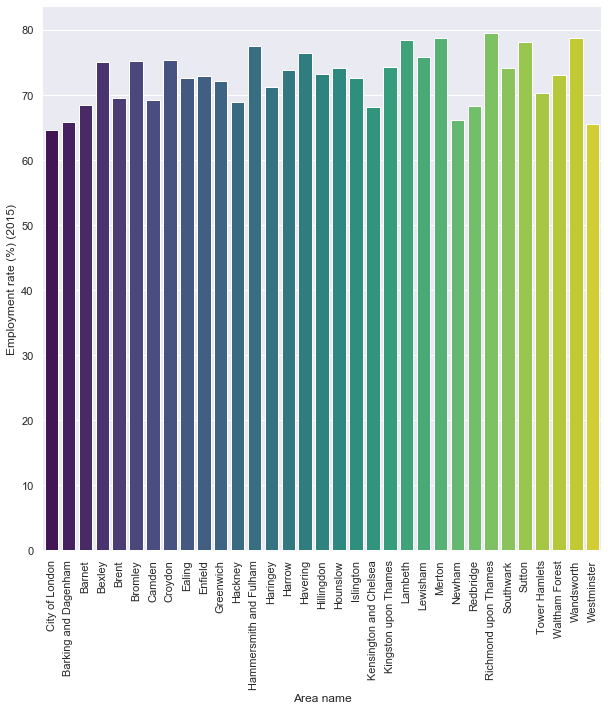

In [44]:
#Visualise the distribution of employment rate across boroughs
sns.barplot(x=PCA_df['Area name'], y=PCA_df['Employment rate (%) (2015)'], palette = "viridis")
plt.xticks(rotation=90)
sns.despine(left=True, bottom=True)

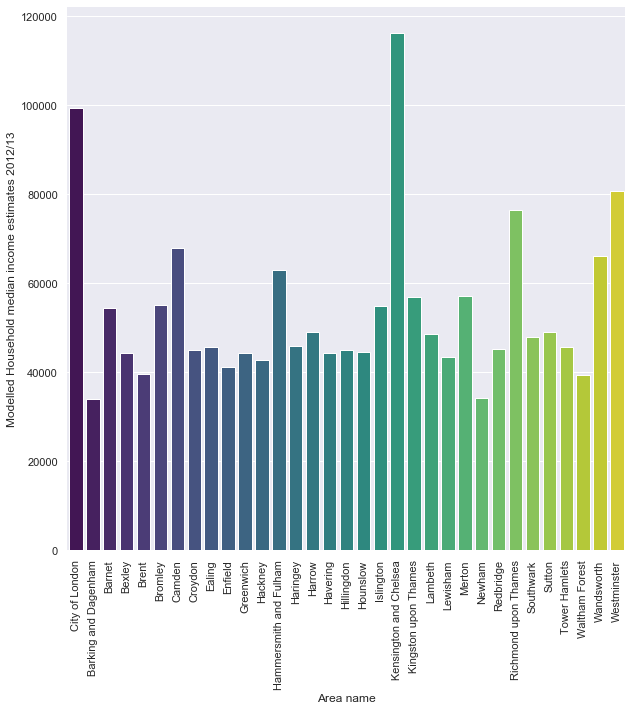

In [45]:
#Visualise the distribution of the household median income across boroughs
sns.barplot(x=PCA_df['Area name'], y=PCA_df['Modelled Household median income estimates 2012/13'],
           palette = "viridis")
plt.xticks(rotation=90)
sns.despine(left=True, bottom=True)

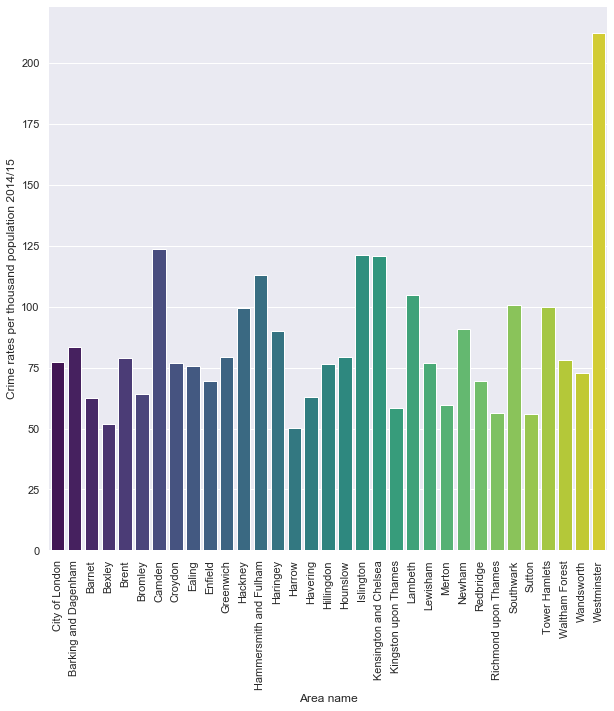

In [46]:
#Visualise the distribution of the crime rates across boroughs
sns.barplot(x=PCA_df['Area name'], y=PCA_df['Crime rates per thousand population 2014/15'],
           palette = "viridis")
plt.xticks(rotation=90)
sns.despine(left=True, bottom=True)

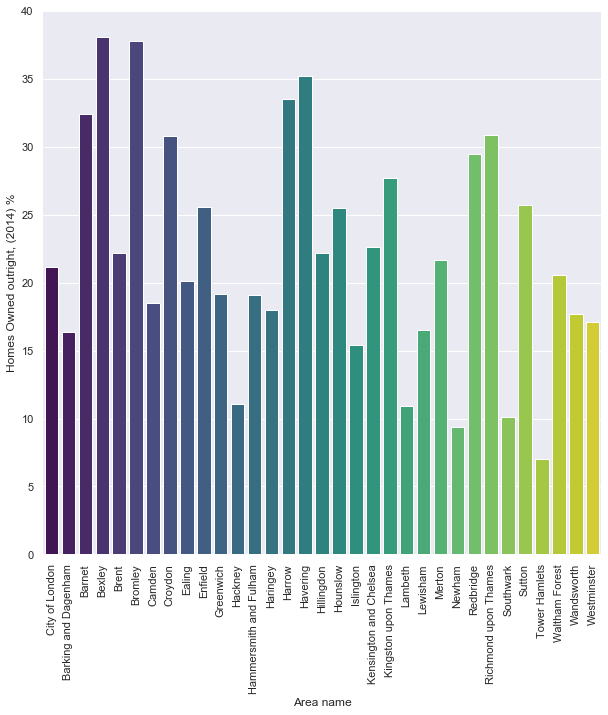

In [47]:
#Visualise the distribution of the homes owned outright across boroughs
sns.barplot(x=PCA_df['Area name'], y=PCA_df['Homes Owned outright, (2014) %'],
           palette = "viridis")
plt.xticks(rotation=90)
sns.despine(left=True, bottom=True)

### 2.2 - PCA with a selection of features

In [48]:
#We only drop the 'identification' features which don't make sense in PCA 
components = PCA_df[['Employment rate (%) (2015)', 'Modelled Household median income estimates 2012/13',
                    'Crime rates per thousand population 2014/15', 'Homes Owned outright, (2014) %',
                    'Happiness score 2011-14 (out of 10)','Anxiety score 2011-14 (out of 10)']]

In [49]:
#Normalize features so that PCA gives relevant results
normalized_components=(components-components.mean())/components.std()

In [50]:
#Do PCA with 2 components 
pca = PCA(n_components=2)
X_reduced_pca = pca.fit(normalized_components).transform(normalized_components)

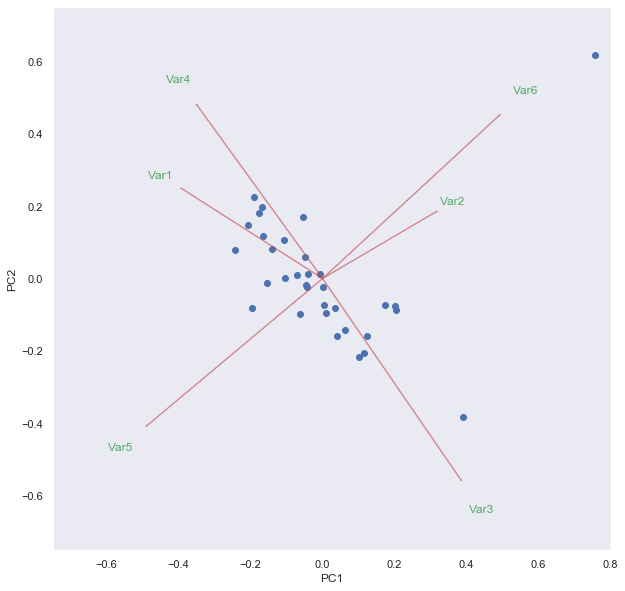

In [51]:
#Function to do a biplot (principal component variance explanation plot)
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = 'b')
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

#Prepare plot            
plt.xlim(-0.75,0.8)
plt.ylim(-0.75,0.75)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Plot the biplot
myplot(X_reduced_pca[:,0:2],np.transpose(pca.components_[0:2, :]))#, components.columns)
plt.show()

For information, here, the variables are numbered as follow:
- 1: Employment rate
- 2: Household median income
- 3: Crime rates
- 4: Homes owned outright
- 5: Happiness score
- 6: Anxiety score

In [52]:
#Find the feature importance for each principal component
print(abs(pca.components_))

[[0.39084452 0.31513159 0.38406473 0.34863846 0.48777947 0.49086591]
 [0.24792    0.18414039 0.55546406 0.47825146 0.40595026 0.4500751 ]]


#### Feature importance in each principal component (PC)
We found that:
- PC1: explained mostly by happiness and anxiety scores
- PC2: explained mostly by crime rates (and homes owned outright and anxiety score)

### 2.2.1 - K-means clustering
Qualitatively, we can observe the PCA components to see if any cluster can be found.

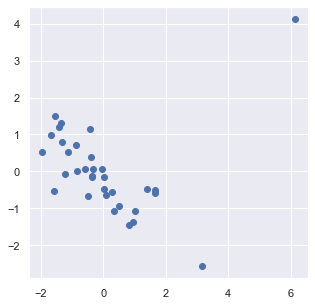

In [53]:
#Plot the PCA components to get an idea of the results and how many clusters can be done with k-means after
fig, axs = plt.subplots(1, 1, figsize=(5,5), sharey=True)
axs.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1])
plt.show()

To determine more precisely (more quantiatively), we use the change in inertia when increasing the number of clusters that K-means should find. We can then obtain a graph with the inertia as a function of the number of clusters implemented in K-means.

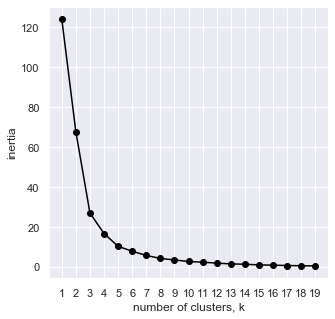

In [54]:
PCA_ = pd.DataFrame(X_reduced_pca)
#Define the optimal number of clusters with K mean clustering
ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_.iloc[:,:2])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
fig, axs = plt.subplots(1, 1, figsize=(5,5), sharey=True)  
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

This graph shows that after 5 clusters the change in the value of inertia is no longer significant and most likely, neither is the variance of the rest of the data after the elbow point. Therefore we chose to implement K-means with 5 clusters.

#### Number of clusters
We found that 5 clusters is the best number of clusters for this embedding.

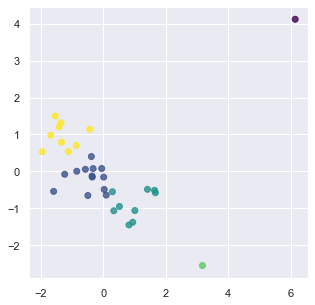

In [55]:
#Use the K-means algorithm to find clusters
fig, axs = plt.subplots(1, 1, figsize=(5,5), sharey=True)

# Plot the clusters with K = 5
km = KMeans(n_clusters=5, random_state=0)#.fit_predict(X_reduced_pca)
labels = km.fit_predict(X_reduced_pca)
axs.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels, alpha=0.8, cmap=plt.get_cmap('viridis'))
plt.show()

### 2.2.2 - Investigate the clusters: which neighborhoods are grouped together?

In [56]:
#Create a data frame by clusters
cluster_map = pd.DataFrame()
cluster_map['Borough'] = PCA_df['Area name'].values
cluster_map['cluster'] = km.labels_
cluster_map['Location'] = PCA_df['InOutLondon'].values

#### We use a map of London to identify the location of the boroughs and see if they are clustered by location. We also aim at explaining why some boroughs are outliers. We describe the clusters.

In [57]:
#This cluster only contains the city of London 
#(It's logical, this is a big outlier for income, 
#but most importantly for the anxiety score: 5.57, mean is 3.35)
cluster_map[cluster_map['cluster']==0]

,Borough,cluster,Location
0,City of London,0,1.0


In [58]:
#North outer London neighborhood + outer border of inner london boroughs
group1 = cluster_map[cluster_map['cluster']==1]
group1

,Borough,cluster,Location
2,Barnet,1,0.0
4,Brent,1,0.0
8,Ealing,1,0.0
9,Enfield,1,0.0
10,Greenwich,1,0.0
12,Hammersmith and Fulham,1,1.0
13,Haringey,1,1.0
16,Hillingdon,1,0.0
17,Hounslow,1,0.0
22,Lewisham,1,1.0


In [59]:
#Visualize some information for the PCA variables in each cluster - cluster 1
group1_df = PCA_df.set_index('Area name').loc[group1['Borough']]
group1_df.describe()

,Employment rate (%) (2015),Modelled Household median income estimates 2012/13,Crime rates per thousand population 2014/15,"Homes Owned outright, (2014) %",Life satisfaction score 2011-14 (out of 10),Worthwhileness score 2011-14 (out of 10),Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10),InOutLondon
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,72.930769,47546.153846,78.638462,22.200000,7.297692,7.573846,7.266154,3.210000,0.307692
std,3.189928,8445.412501,12.254016,4.793572,0.090844,0.099124,0.086558,0.309112,0.480384
min,68.300000,39460.000000,62.700000,16.500000,7.180000,7.350000,7.120000,2.600000,0.000000
25%,71.300000,43360.000000,72.600000,19.100000,7.240000,7.530000,7.200000,3.090000,0.000000
50%,73.000000,44950.000000,77.000000,20.600000,7.290000,7.570000,7.260000,3.200000,0.000000
75%,74.200000,45860.000000,79.200000,25.500000,7.370000,7.630000,7.330000,3.430000,1.000000
max,78.800000,66220.000000,113.200000,32.400000,7.480000,7.760000,7.400000,3.590000,1.000000


In [60]:
#This cluster is (almost) exclusively composed of inner london boroughs 
group2 = cluster_map[cluster_map['cluster']==2]
group2

,Borough,cluster,Location
1,Barking and Dagenham,2,0.0
6,Camden,2,1.0
11,Hackney,2,1.0
18,Islington,2,1.0
19,Kensington and Chelsea,2,1.0
21,Lambeth,2,1.0
24,Newham,2,1.0
27,Southwark,2,1.0
29,Tower Hamlets,2,1.0


In [61]:
#Visualize some information for the PCA variables in each cluster - cluster 2
group2_df = PCA_df.set_index('Area name').loc[group2['Borough']]
group2_df.describe()

,Employment rate (%) (2015),Modelled Household median income estimates 2012/13,Crime rates per thousand population 2014/15,"Homes Owned outright, (2014) %",Life satisfaction score 2011-14 (out of 10),Worthwhileness score 2011-14 (out of 10),Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10),InOutLondon
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,70.455556,54738.888889,104.944444,13.488889,7.226667,7.495556,7.184444,3.422222,0.888889
std,4.060514,25316.082065,14.143736,5.036974,0.187750,0.159774,0.171108,0.252378,0.333333
min,65.800000,34080.000000,83.400000,7.000000,7.030000,7.310000,6.990000,3.050000,0.000000
25%,68.200000,42690.000000,99.600000,10.100000,7.140000,7.390000,7.060000,3.260000,1.000000
50%,69.200000,48000.000000,100.600000,11.100000,7.140000,7.430000,7.180000,3.420000,1.000000
75%,72.600000,54950.000000,120.900000,16.400000,7.220000,7.600000,7.200000,3.610000,1.000000
max,78.500000,116350.000000,123.500000,22.600000,7.610000,7.800000,7.560000,3.760000,1.000000


In [62]:
#This cluster only contains westmister, which is probably an outlier due to the crime rates 
#(very very high compared to others)
cluster_map[cluster_map['cluster']==3]

,Borough,cluster,Location
32,Westminster,3,1.0


In [63]:
PCA_df[PCA_df['Area name'] == 'Westminster']

,New code,Area name,Inner/ Outer London,Employment rate (%) (2015),Modelled Household median income estimates 2012/13,Crime rates per thousand population 2014/15,"Homes Owned outright, (2014) %",Life satisfaction score 2011-14 (out of 10),Worthwhileness score 2011-14 (out of 10),Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10),InOutLondon
33,E09000033,Westminster,Inner London,65.6,80760,212.4,17.1,7.25,7.45,7.13,3.43,1.0


In [64]:
#This cluster is composed only of outer london boroughs: all these neighborhoods are at the extreme outer of London
#They are probably linked together because the outer london boroughs have common characteristics
group4 = cluster_map[cluster_map['cluster']==4]
group4

,Borough,cluster,Location
3,Bexley,4,0.0
5,Bromley,4,0.0
7,Croydon,4,0.0
14,Harrow,4,0.0
15,Havering,4,0.0
20,Kingston upon Thames,4,0.0
23,Merton,4,0.0
26,Richmond upon Thames,4,0.0
28,Sutton,4,0.0


In [65]:
#Visualize some information for the PCA variables in each cluster - cluster 4
group4_df = PCA_df.set_index('Area name').loc[group4['Borough']]
group4_df.describe()

,Employment rate (%) (2015),Modelled Household median income estimates 2012/13,Crime rates per thousand population 2014/15,"Homes Owned outright, (2014) %",Life satisfaction score 2011-14 (out of 10),Worthwhileness score 2011-14 (out of 10),Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10),InOutLondon
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0
mean,76.355556,53115.555556,59.622222,31.266667,7.373333,7.652222,7.275556,3.234444,0.0
std,2.042738,10208.698633,7.946505,5.538727,0.136839,0.128138,0.105132,0.222380,0.0
min,73.900000,44430.000000,50.400000,21.700000,7.100000,7.420000,7.130000,2.710000,0.0
25%,75.100000,45120.000000,55.900000,27.700000,7.330000,7.570000,7.210000,3.220000,0.0
50%,75.400000,49170.000000,58.500000,30.900000,7.380000,7.680000,7.260000,3.280000,0.0
75%,78.200000,56920.000000,62.900000,35.200000,7.460000,7.700000,7.330000,3.290000,0.0
max,79.600000,76610.000000,77.000000,38.100000,7.540000,7.860000,7.440000,3.560000,0.0


#### Conclusion for this part of the question 2:
We established 5 groups, and we found that boroughs that were clustered together usually belong to the same London geographic region. They are two outliers, the City of London and Westminster, which can be expected to be outliers from some of their characteristics.

# Question 3: Can we predict political control based on life satisfaction, neighbourhoods and housing conditions?

That question is about the political control in council in the different boroughs.
We investigate the possibility to have differences between boroughs with labour-controlled council and conservative-controlled council, when looking at many variables, such as the well-being ones (part 1), and others such as home payement, neighborhood infos, etc (part 2 of this question). 

To investigate whether there are any significant differences, we are going to see if they are significant differences between the variable mean for the labour-controlled boroughs and the conservative-controlled ones. 

- First, we will visualize the mean differences between the two political types of boroughs. 
- Then, we will observe the distribution of the variables in two types of boroughs, to see if there is any visual differences. 
- Finally, we will assess the differences with a statistical test: t-test, which is appropriate to compare the means of two groups.

## 3.1 - FIRST PART: Differences for the well-being variables between labour and conservative boroughs
We will first see if the life satisfaction, worthwhileness, happiness and anxiety means are different for labour boroughs and conservative boroughs.

We select the following variables:
- Political control in council
- Life satisfaction score
- Worthwhileness score
- Happiness score
- Anxiety score
- Inner/outer London (to drop non-borough rows)

### 3.1.1 - Data Pre-processing
#### Select variables that are useful in this first part

In [66]:
#Select variables of interest
boroughs_pol = boroughs[['Political control in council','Life satisfaction score 2011-14 (out of 10)',
                     'Worthwhileness score 2011-14 (out of 10)','Happiness score 2011-14 (out of 10)',
                     'Anxiety score 2011-14 (out of 10)','Inner/ Outer London']]

#Get rid of NaN (only in the inner/outer london column) so that we get rid of non-borough rows
boroughs_pol = boroughs_pol.replace('.', np.nan)
boroughs_pol = boroughs_pol[~boroughs_pol['Inner/ Outer London'].isna()]

In [67]:
#Separate the boroughs into two groups, labour and conservative control:
boroughs_lab = boroughs_pol[boroughs_pol['Political control in council']=='Lab']
boroughs_cons = boroughs_pol[boroughs_pol['Political control in council'] == 'Cons']

### 3.1.2 - Check the means for the two groups for all variables to see if some differences are possible

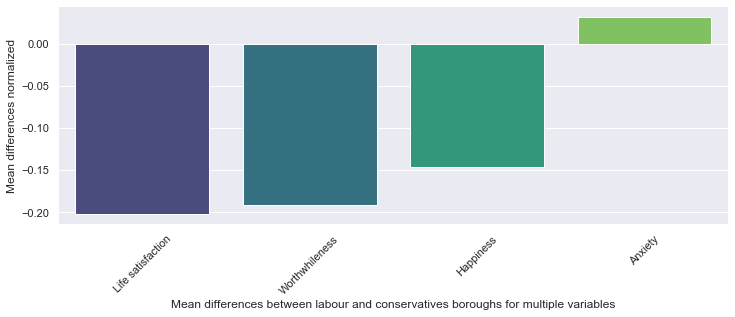

In [68]:
#Stored the means from the describe to see if they are different
lab_means = boroughs_lab.describe(include = "all").loc['mean']
cons_means = boroughs_cons.describe(include = "all").loc['mean']

#Drop NaN means, it is for non numerical columns so not interesting!
lab_means = lab_means.dropna()
cons_means = cons_means.dropna()

#see the differences of means between the two parties and plot it
diff_means = lab_means - cons_means
new_index = ['Life satisfaction', 'Worthwhileness', 'Happiness', 'Anxiety']

#Visualise the means
f, ax = plt.subplots(figsize=(12, 4))
sns.barplot(new_index, diff_means, palette = "viridis")
ax.set(xlabel="Mean differences between labour and conservatives boroughs for multiple variables", ylabel = 'Mean differences normalized')
sns.despine(left=True, bottom=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

### 3.1.3 - Plotting the distributions to check for visual differences between labour and conservatives boroughs

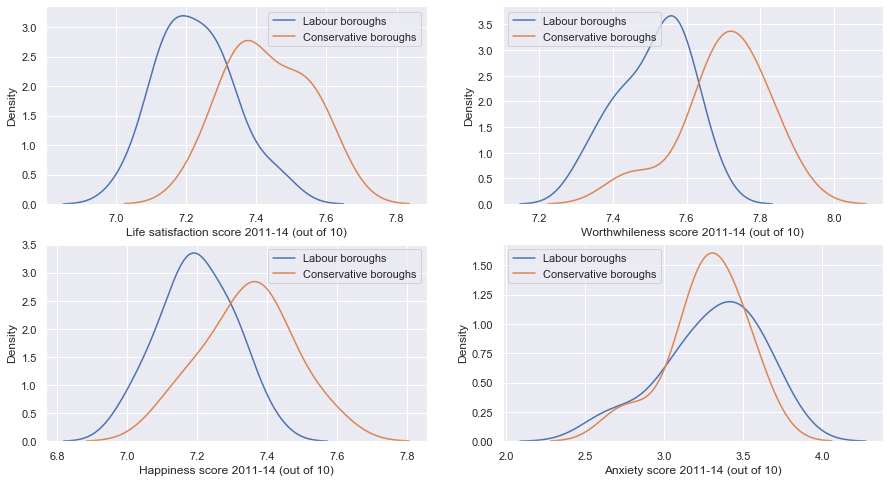

In [69]:
#Plot the distribution of the variables for the four well-being variables
fig, axs = plt.subplots(2, 2, figsize=(15,8))
        
sns.distplot(boroughs_lab['Life satisfaction score 2011-14 (out of 10)'], hist=False, 
             label = 'Labour boroughs', ax = axs[0,0])
sns.distplot(boroughs_cons['Life satisfaction score 2011-14 (out of 10)'], hist=False,
             label = 'Conservative boroughs', ax = axs[0,0])
axs[0,0].legend()

sns.distplot(boroughs_lab['Worthwhileness score 2011-14 (out of 10)'], hist=False, 
             label = 'Labour boroughs', ax = axs[0,1])
sns.distplot(boroughs_cons['Worthwhileness score 2011-14 (out of 10)'], hist=False,
             label = 'Conservative boroughs', ax = axs[0,1])
axs[0,1].legend()

sns.distplot(boroughs_lab['Happiness score 2011-14 (out of 10)'], hist=False, 
             label = 'Labour boroughs', ax = axs[1,0])
sns.distplot(boroughs_cons['Happiness score 2011-14 (out of 10)'], hist=False,
             label = 'Conservative boroughs', ax = axs[1,0])
axs[1,0].legend()

sns.distplot(boroughs_lab['Anxiety score 2011-14 (out of 10)'], hist=False, 
             label = 'Labour boroughs', ax = axs[1,1])
sns.distplot(boroughs_cons['Anxiety score 2011-14 (out of 10)'], hist=False,
             label = 'Conservative boroughs', ax = axs[1,1])
axs[1,1].legend()

plt.show()

### 3.1.4 - Doing some statistical tests to see if the differences are significant
We use some t-tests.

In [70]:
#Do the t-tests for the means of the four well-being variables
#Store the p-value for graph: we will plot 1-p for visualisation reasons
p_satis = 1-np.round(stats.ttest_ind(boroughs_lab['Life satisfaction score 2011-14 (out of 10)'],
                                        boroughs_cons['Life satisfaction score 2011-14 (out of 10)']).pvalue, 4)
p_worth = 1-np.round(stats.ttest_ind(boroughs_lab['Worthwhileness score 2011-14 (out of 10)'],
                                        boroughs_cons['Worthwhileness score 2011-14 (out of 10)']).pvalue, 4)
p_happy = 1-np.round(stats.ttest_ind(boroughs_lab['Happiness score 2011-14 (out of 10)'],
                                        boroughs_cons['Happiness score 2011-14 (out of 10)']).pvalue, 4)
p_anxiety = 1-np.round(stats.ttest_ind(boroughs_lab['Anxiety score 2011-14 (out of 10)'],
                                        boroughs_cons['Anxiety score 2011-14 (out of 10)']).pvalue, 4)

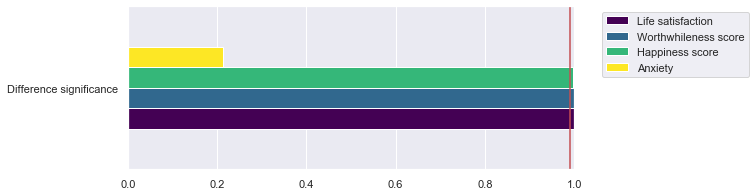

In [71]:
#Make small data frame with 1-pvalue to ease the plotting
data={'Life satisfaction': p_satis,'Worthwhileness score':p_worth,
      'Happiness score':p_happy,'Anxiety': p_anxiety,}

pval=pd.DataFrame(data, index=['Difference significance'],
                    columns = ['Life satisfaction','Worthwhileness score',
                               'Happiness score', 'Anxiety'])

#Plot the 1-pvalue. We chose this to ease visualisation and to make it more visual
#The closer to 1, the more significant difference there is between the two groups
print('\n')
pval.plot(kind="barh", width=0.5, figsize=(8,3), cmap=plt.get_cmap('viridis'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.title('Mean difference significance between labour and conservatives neighborhoods. 1-pvalue is shown.')
plt.xlim(0,1)
plt.axvline(0.99,0,1,color='r')
plt.show()

#### Conclusion for this part of the question 3:
We see that as expected from the distribution seen before, happiness, life satisfaction and worthwhileness means are significantly different between the two political types of boroughs, at a signifiance level of 0.01. However, it is not the case for the anxiety score, as expected from the distribution.

## 3.2 - SECOND PART: Investigating further differences
We will now extend the possibility to have differences between the two types of boroughs to various other variables such as age, income, home payement type, neighborhood characteristics ...

Here are the variables that we select:
- Political control in council
- Employment rate
- Household median income
- Crime rates per thousand population
- Homes owned outright
- Being bought with mortgage or loan
- Rented from local authority or housing association
- Average age
- Population density
- Proportion of population of working-age
- Proportion of population aged 65 and over
- Median house price
- % of area that is greenspace
- Inner/outer London (to drop non-borough rows)

### 3.2.1 - Data Pre-processing

Select variables that could be useful:

In [72]:
#Select variables
boroughs_pol2 = boroughs[['Political control in council','Employment rate (%) (2015)',
                               'Modelled Household median income estimates 2012/13',
                               'Crime rates per thousand population 2014/15',
                               'Homes Owned outright, (2014) %', 
                               'Being bought with mortgage or loan, (2014) %',
                               'Rented from Local Authority or Housing Association, (2014) %', 
                               'Average Age, 2016','Number of cars per household, (2011 Census)',
                               'Population density (per hectare) 2016',
                               'Proportion of population of working-age, 2016',
                               'Proportion of population aged 65 and over, 2016','Median House Price, 2014', 
                               '% of area that is Greenspace, 2005','Inner/ Outer London']]

#Drop NaN rows in inner/outer london column
boroughs_pol2 = boroughs_pol2.replace('.', np.nan)
boroughs_pol2 = boroughs_pol2[~boroughs_pol2['Inner/ Outer London'].isna()]

In [73]:
#Get out any sign that cannot be converted directly to numeric
boroughs_pol2['Modelled Household median income estimates 2012/13'] = boroughs_pol2['Modelled Household median income estimates 2012/13'].str.replace('£','')
boroughs_pol2['Modelled Household median income estimates 2012/13'] = boroughs_pol2['Modelled Household median income estimates 2012/13'].str.replace(',','')

boroughs_pol2['Median House Price, 2014'] = boroughs_pol2['Median House Price, 2014'].str.replace(',','')

In [74]:
#Put object dtypes to numeric when the variables is numeric
boroughs_pol2['Modelled Household median income estimates 2012/13'] = pd.to_numeric(boroughs_pol2['Modelled Household median income estimates 2012/13'])

boroughs_pol2['Crime rates per thousand population 2014/15'] = pd.to_numeric(boroughs_pol2['Crime rates per thousand population 2014/15'])
boroughs_pol2['Median House Price, 2014'] = pd.to_numeric(boroughs_pol2['Median House Price, 2014'])
boroughs_pol2['Population density (per hectare) 2016'] = pd.to_numeric(boroughs_pol2['Population density (per hectare) 2016'])
boroughs_pol2['% of area that is Greenspace, 2005'] = pd.to_numeric(boroughs_pol2['% of area that is Greenspace, 2005'])

boroughs_pol2['Modelled Household median income estimates 2012/13'] = pd.to_numeric(boroughs_pol2['Modelled Household median income estimates 2012/13'])

boroughs_pol2['Crime rates per thousand population 2014/15'] = pd.to_numeric(boroughs_pol2['Crime rates per thousand population 2014/15'])
boroughs_pol2['Homes Owned outright, (2014) %'] = pd.to_numeric(boroughs_pol2['Homes Owned outright, (2014) %'])
boroughs_pol2['Being bought with mortgage or loan, (2014) %'] = pd.to_numeric(boroughs_pol2['Being bought with mortgage or loan, (2014) %'])
boroughs_pol2['Rented from Local Authority or Housing Association, (2014) %'] = pd.to_numeric(boroughs_pol2['Rented from Local Authority or Housing Association, (2014) %'])

In [75]:
#Separate the boroughs into two groups, labour and conservative control:
boroughs_lab = boroughs_pol2[boroughs_pol2['Political control in council']=='Lab']
boroughs_cons = boroughs_pol2[boroughs_pol2['Political control in council'] == 'Cons']

### 3.2.2 - Check the means for the two groups for all variables to see if some differences are possible

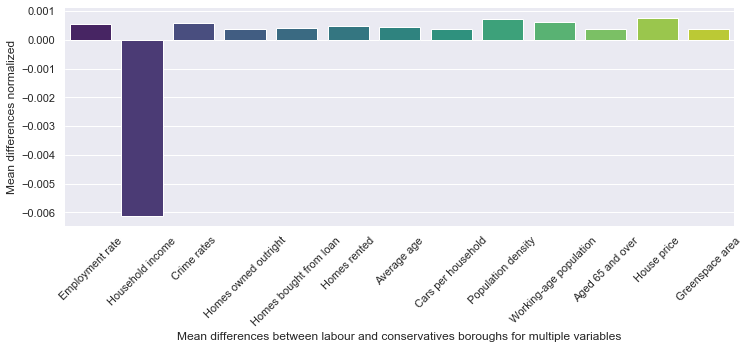

In [76]:
#Stored the means to see if they are different
lab_means = boroughs_lab.describe(include = "all").loc['mean']
cons_means = boroughs_cons.describe(include = "all").loc['mean']

#Drop NaN means, it is for non numerical columns so not interesting!
lab_means = lab_means.dropna()
cons_means = cons_means.dropna()

#See the differences of means between the two parties and plot it
#First, normalize as we visualize several types of units at the same time
lab_means = (lab_means - lab_means.mean())/lab_means.std()
cons_means = (cons_means - cons_means.mean())/cons_means.std()


diff_means = lab_means - cons_means

#Ease reading with simpler variable names
new_index = ['Employment rate', 'Household income', 'Crime rates','Homes owned outright', 'Homes bought from loan',
             'Homes rented', 'Average age','Cars per household', 'Population density', 
             'Working-age population', 'Aged 65 and over','House price', 'Greenspace area']

f, ax = plt.subplots(figsize=(12, 4))
sns.barplot(new_index, diff_means, palette = "viridis")
ax.set(xlabel="Mean differences between labour and conservatives boroughs for multiple variables", ylabel = 'Mean differences normalized')
sns.despine(left=True, bottom=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

### 3.2.3 - Plotting the distributions to check for visual differences between labour and conservatives boroughs

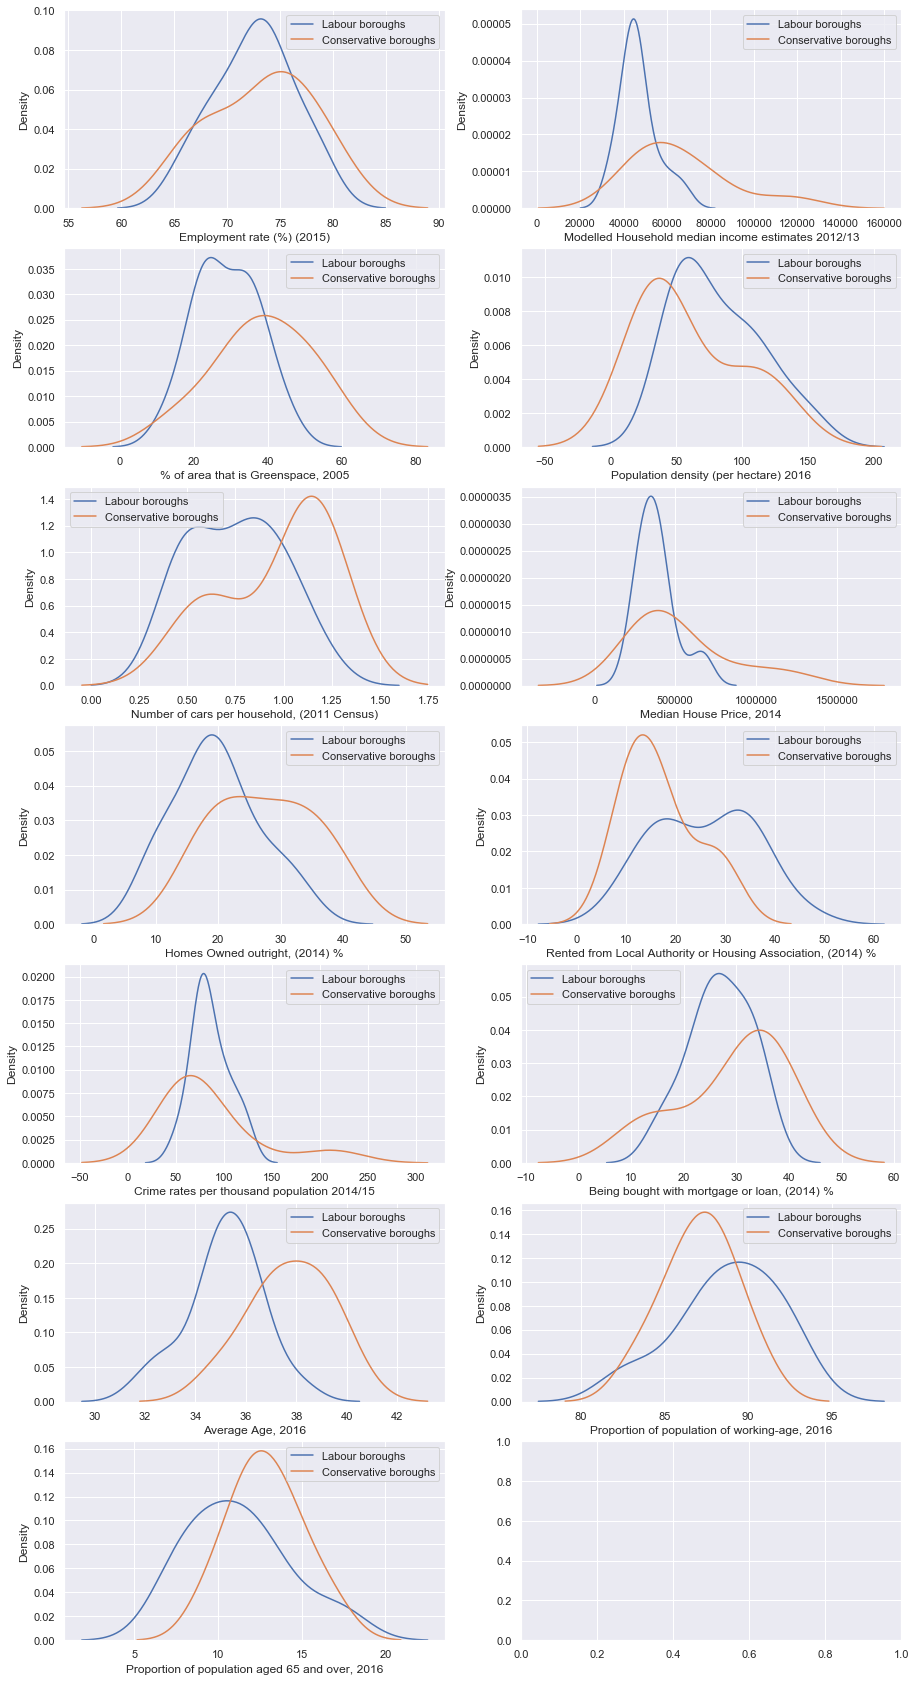

In [77]:
#Plot the distribution of the variables
fig, axs = plt.subplots(7, 2, figsize=(15,30))
        
#FIRST LINE
sns.distplot(boroughs_lab['Employment rate (%) (2015)'], hist=False, 
             label = 'Labour boroughs', ax = axs[0,0])
sns.distplot(boroughs_cons['Employment rate (%) (2015)'], hist=False,
             label = 'Conservative boroughs', ax = axs[0,0])
axs[0,0].legend()

sns.distplot(boroughs_lab['Modelled Household median income estimates 2012/13'], hist=False,
             label = 'Labour boroughs', ax = axs[0,1])
sns.distplot(boroughs_cons['Modelled Household median income estimates 2012/13'], hist=False,
             label = 'Conservative boroughs', ax = axs[0,1])
axs[0,1].legend()

#SECOND LINE
sns.distplot(boroughs_lab['% of area that is Greenspace, 2005'], hist=False,
             label = 'Labour boroughs', ax = axs[1,0])
sns.distplot(boroughs_cons['% of area that is Greenspace, 2005'], hist=False,
             label = 'Conservative boroughs', ax = axs[1,0])
axs[1,0].legend()

sns.distplot(boroughs_lab['Population density (per hectare) 2016'], hist=False, 
             label = 'Labour boroughs', ax = axs[1,1])
sns.distplot(boroughs_cons['Population density (per hectare) 2016'], hist=False,
             label = 'Conservative boroughs', ax = axs[1,1])
axs[1,1].legend()

#THIRD LINE
sns.distplot(boroughs_lab['Number of cars per household, (2011 Census)'], hist=False, 
             label = 'Labour boroughs', ax = axs[2,0])
sns.distplot(boroughs_cons['Number of cars per household, (2011 Census)'], hist=False,
             label = 'Conservative boroughs', ax = axs[2,0])
axs[2,0].legend()

sns.distplot(boroughs_lab['Median House Price, 2014'], hist=False, 
             label = 'Labour boroughs', ax = axs[2,1])
sns.distplot(boroughs_cons['Median House Price, 2014'], hist=False,
             label = 'Conservative boroughs', ax = axs[2,1])
axs[2,1].legend()

#FOURTH LINE
sns.distplot(boroughs_lab['Homes Owned outright, (2014) %'], hist=False, 
             label = 'Labour boroughs', ax = axs[3,0])
sns.distplot(boroughs_cons['Homes Owned outright, (2014) %'], hist=False,
             label = 'Conservative boroughs', ax = axs[3,0])
axs[3,0].legend()

sns.distplot(boroughs_lab['Rented from Local Authority or Housing Association, (2014) %'], hist=False, 
             label = 'Labour boroughs', ax = axs[3,1])
sns.distplot(boroughs_cons['Rented from Local Authority or Housing Association, (2014) %'], hist=False,
             label = 'Conservative boroughs', ax = axs[3,1])
axs[3,1].legend()

#FIFTH LINE
sns.distplot(boroughs_lab['Crime rates per thousand population 2014/15'], hist=False, 
             label = 'Labour boroughs', ax = axs[4,0])
sns.distplot(boroughs_cons['Crime rates per thousand population 2014/15'], hist=False,
             label = 'Conservative boroughs', ax = axs[4,0])
axs[4,0].legend()

sns.distplot(boroughs_lab['Being bought with mortgage or loan, (2014) %'], hist=False, 
             label = 'Labour boroughs', ax = axs[4,1])
sns.distplot(boroughs_cons['Being bought with mortgage or loan, (2014) %'], hist=False,
             label = 'Conservative boroughs', ax = axs[4,1])
axs[4,1].legend()

#SIXTH LINE
sns.distplot(boroughs_lab['Average Age, 2016'], hist=False, 
             label = 'Labour boroughs', ax = axs[5,0])
sns.distplot(boroughs_cons['Average Age, 2016'], hist=False,
             label = 'Conservative boroughs', ax = axs[5,0])
axs[5,0].legend()

sns.distplot(boroughs_lab['Proportion of population of working-age, 2016'], hist=False, 
             label = 'Labour boroughs', ax = axs[5,1])
sns.distplot(boroughs_cons['Proportion of population of working-age, 2016'], hist=False,
             label = 'Conservative boroughs', ax = axs[5,1])
axs[5,1].legend()

#SEVENTH LINE
sns.distplot(boroughs_lab['Proportion of population aged 65 and over, 2016'], hist=False, 
             label = 'Labour boroughs', ax = axs[6,0])
sns.distplot(boroughs_cons['Proportion of population aged 65 and over, 2016'], hist=False,
             label = 'Conservative boroughs', ax = axs[6,0])
axs[6,0].legend()

plt.show()

### 3.2.4 - Doing some statistical tests to see if the differences are significant
We use some t-tests again.

In [78]:
#Do the t-tests for the means of the variables
#Store the p-value for graph: we will plot 1-p for visualisation reasons
p_income = 1-np.round(stats.ttest_ind(boroughs_lab['Modelled Household median income estimates 2012/13'],
                           boroughs_cons['Modelled Household median income estimates 2012/13']).pvalue, 4)
p_greenspace = 1-np.round(stats.ttest_ind(boroughs_lab['% of area that is Greenspace, 2005'],
                                        boroughs_cons['% of area that is Greenspace, 2005']).pvalue, 4)
p_density = 1-np.round(stats.ttest_ind(boroughs_lab['Population density (per hectare) 2016'],
                                        boroughs_cons['Population density (per hectare) 2016']).pvalue, 4)
p_cars = 1-np.round(stats.ttest_ind(boroughs_lab['Number of cars per household, (2011 Census)'],
                                        boroughs_cons['Number of cars per household, (2011 Census)']).pvalue, 4)
p_price = 1-np.round(stats.ttest_ind(boroughs_lab['Median House Price, 2014'],
                                    boroughs_cons['Median House Price, 2014']).pvalue, 4)
p_rent = 1-np.round(stats.ttest_ind(boroughs_lab['Rented from Local Authority or Housing Association, (2014) %'],
                                        boroughs_cons['Rented from Local Authority or Housing Association, (2014) %']).pvalue, 4)
p_outright = 1-np.round(stats.ttest_ind(boroughs_lab['Homes Owned outright, (2014) %'],
                                        boroughs_cons['Homes Owned outright, (2014) %']).pvalue, 4)
p_crime = 1-np.round(stats.ttest_ind(boroughs_lab['Crime rates per thousand population 2014/15'],
                                        boroughs_cons['Crime rates per thousand population 2014/15']).pvalue, 4)
p_loan = 1-np.round(stats.ttest_ind(boroughs_lab['Being bought with mortgage or loan, (2014) %'],
                                        boroughs_cons['Being bought with mortgage or loan, (2014) %']).pvalue, 4)
p_age = 1-np.round(stats.ttest_ind(boroughs_lab['Average Age, 2016'],
                                        boroughs_cons['Average Age, 2016']).pvalue, 4)
p_working = 1-np.round(stats.ttest_ind(boroughs_lab['Proportion of population of working-age, 2016'],
                                        boroughs_cons['Proportion of population of working-age, 2016']).pvalue, 4)
p_65 = 1-np.round(stats.ttest_ind(boroughs_lab['Proportion of population aged 65 and over, 2016'],
                                        boroughs_cons['Proportion of population aged 65 and over, 2016']).pvalue, 4)

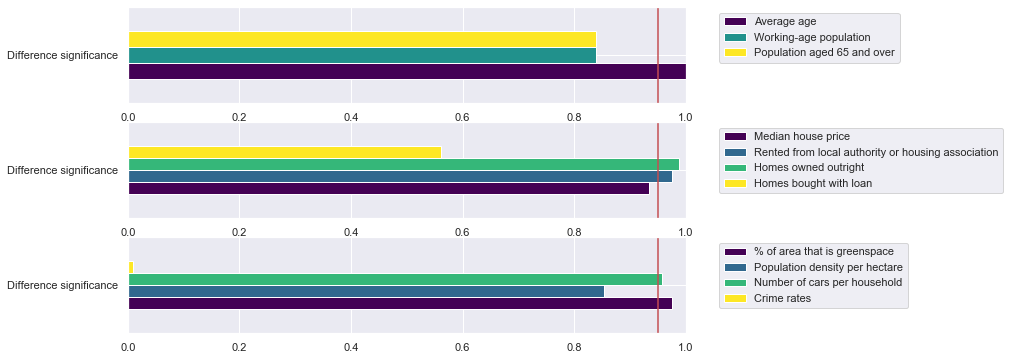

In [79]:
#Make some small data frames with 1-pvalue to ease the plotting
data={'Household median income':p_income, '% of area that is greenspace': p_greenspace, 
      'Population density per hectare':p_density,'Number of cars per household':p_cars,
      'Median house price': p_price,'Rented from local authority or housing association':p_rent,
      'Homes owned outright':p_outright,'Crime rates': p_crime,
     'Homes bought with loan':p_loan, 'Average age':p_age, 
    'Average age':p_age, 'Working-age population':p_working,
     'Population aged 65 and over':p_65}

pval=pd.DataFrame(data, index=['Difference significance'],
                    columns = ['Average age',
                              'Working-age population','Population aged 65 and over'])

pval2=pd.DataFrame(data, index=['Difference significance'],
                    columns = ['Median house price',
                                'Rented from local authority or housing association',
                                'Homes owned outright','Homes bought with loan'])

pval3=pd.DataFrame(data, index=['Difference significance'],
                    columns = ['% of area that is greenspace', 
                               'Population density per hectare',
                               'Number of cars per household','Crime rates'])

#To ease visualisation, we separate the variables into three subplots: 
#the age variables, the variables relating to homes, and the neighborhood information variables
print('\n')
#Plot the 1-pvalue. We chose this to ease visualisation and to make it more visual
#The closer to 1, the more significant the means are different between the two groups
fig, axs = plt.subplots(3, 1, figsize=(10,6))
pval.plot(kind="barh", width=0.5, ax = axs[0], cmap=plt.get_cmap('viridis'))
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].set_xlim(0,1)
axs[0].axvline(0.95,0,1,color='r')

pval2.plot(kind="barh", width=0.5, ax = axs[1], cmap=plt.get_cmap('viridis'))
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].set_xlim(0,1)
axs[1].axvline(0.95,0,1,color='r')

pval3.plot(kind="barh", width=0.5, ax = axs[2], cmap=plt.get_cmap('viridis'))
axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[2].set_xlim(0,1)
axs[2].axvline(0.95,0,1,color='r')

plt.show()

#### Conclusion for this part of the question 3:
Here we used a significance level of 0.05, and we find that the average age, the proportion of homes owned outright, the proportion of homes rented, the greenspace area and the number of cars per households, are all signicantly different between the two groups of boroughs: labour and conservative.

However, the proportions of working-age patients and people aged 65 and over, as well as the homes bought with loan, the median house price, the crime rates and the population density, are not statistically different for the labour-controlled and conservative-controlled borough groups.